# Association between omics support and target clinical success

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import json

import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [23]:
from sc_target_evidence_utils import association_utils, sc_evidence_utils
import upsetplot

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
figdir = '/home/jovyan/mount/gdrive/sc_targetID/plots/association_results/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [8]:
def _palette_df_from_dict(palette_dict):
    palette_df = pd.DataFrame(palette_dict.values(), index=palette_dict.keys())
    palette_df.columns = ['color']
    return(palette_df)
    
## Gene classes 
GENE_CLASS_ORDER = ['nuclear_receptors', 'catalytic_receptors', 'rhodop_gpcr', 'transporters', 'kinases', 'enzymes', 'ion_channels', 'other']
gene_class_palette = {
    x:sns.color_palette('Set1').as_hex()[i] if x != 'other' else sns.color_palette('Set1').as_hex()[-1] for i,x in enumerate(GENE_CLASS_ORDER)
}
gene_class_palette_df = _palette_df_from_dict(gene_class_palette)

In [9]:
%%R -i gene_class_palette_df -i figdir
gene_class_palette <- setNames(gene_class_palette_df$color, rownames(gene_class_palette_df))

# utils
ggsave_figdir <- function(output_name, width, height){
    ggsave(paste0(figdir, output_name, '.png'), width = width, height = height) 
    ggsave(paste0(figdir, output_name, '.pdf'), width = width, height = height)
}


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [10]:
## Get disease info from curated metadata
data_dir = "/nfs/team205/ed6/bin/sc_target_evidence/data/"
cxg_metadata = pd.read_csv(data_dir + 'cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

disease_info_df = cxg_metadata[['disease_relevant_tissue', 'disease_ontology_id', 'disease']].drop_duplicates()
disease_name_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease']))
disease_tissue_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease_relevant_tissue']))

In [11]:
tissue_colors = sc.pl.palettes.default_20
tissue_palette_dict = dict(zip(disease_info_df['disease_relevant_tissue'].unique(), tissue_colors))
tissue_palette_df = _palette_df_from_dict(tissue_palette_dict)

In [12]:
%%R -i tissue_palette_df -i figdir
tissue_palette <- setNames(tissue_palette_df$color, rownames(tissue_palette_df))



/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [13]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

In [75]:
%%R

### Plotting utils
evidence_labels <- c(
    "all_sc_evidence" = "cell type & disease cell specific", 
    "bulk_disease_evidence" = "DE in disease (tissue)", 
    "disease_ct_evidence" = "DE in disease (cell type)", 
    "disease_evidence" = "Disease cell specific", 
    "ct_marker_evidence" = "Cell type specific", 
    "has_genetic_support" = "Genetic association"
    )

universe_labels <- c(
    'protein_coding_targets'= 'protein-coding targets',
    'sm_tractable_targets' = 'SM tractable targets',
    'ab_tractable_targets' = "Ab tractable targets",
    'known_drug_targets' = 'known drug targets\n(reached phase I)',
    'nuclear_receptors' = 'nuclear receptors', 
    'catalytic_receptors' = 'catalytic receptors', 
    'rhodop_gpcr' = 'rhodopsin-like\nGPCRs', 
    'transporters' = 'transporters', 
    'kinases' = 'kinases', 
    'enzymes' = 'enzymes', 
    'ion_channels' = 'ion channels'
    )


# Plot odds-ratio (no faceting)
plot_OR <- function(
    results_all_df, 
    pval_alpha=0.05, 
    base_font_size=20,
    text_position='right',
    y_value = 'clinical_status',
    evidence_levels = c('ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence', 'has_genetic_support', 'all_sc_evidence', 'is_hvg_normal', 'is_hvg_disease'),
    clinical_status_levels = c(rev(c('druggable', 'safe', 'effective', 'approved'))),
    hide_zeros = TRUE
){
    pl_df <- results_all_df %>%
        mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=clinical_status_levels)) %>%
        mutate(evidence = factor(evidence, levels=evidence_levels)) %>%
        mutate(is_signif = pval < pval_alpha) %>%
        rename(setNames(y_value,'y_val')) 
    
    pl <- ggplot(pl_df, aes(y=y_val, x=odds_ratio, color=is_signif)) 
    
    if (isTRUE(hide_zeros)){
        pl <- pl +
            geom_point(
                data = . %>% filter(n_supported_approved > 0),
                size=3
            ) +
            geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                            aes(xmin=ci_low, xmax=ci_high))
    } else {
        pl <- pl +
            geom_point(size=3) +
            geom_pointrange(aes(xmin=ci_low, xmax=ci_high))}
        
    pl <- pl + geom_text(aes(label = paste0(n_supported_approved,' / ', n_success)), 
                      x = ifelse(text_position == 'right', Inf, -Inf) , 
                      hjust= ifelse(text_position == 'right', 1.1, -1) , 
                      size=5,
                      color='black',) +
        geom_vline(xintercept=1, linetype=2) +
        scale_x_log10(labels = scales::label_number()) +
        xlab('Odds Ratio') +
        ylab(y_value) +
        theme_classic(base_size=base_font_size) +
        scale_color_manual(values=c('TRUE' = 'red', 'FALSE'='grey50'), 
                           name=paste0("Significant enrichment\n(Fisher's test p-value < ", round(pval_alpha, digits=2), ')')) +
        theme(strip.text.y=element_text(angle=0), strip.background = element_rect(color=NA, fill = "grey"))    
    pl
}

## Reproducing association with genetics evidence

In [15]:
## Read OT evidence table
OT_targets_df =  pd.read_csv(data_dir + 'TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.clean.csv', index_col=0)
OT_targets_df['has_genetic_support'] = (OT_targets_df['genetic_association'] > 0).astype(int)

Get dictionary for all the universes (to use when the same universe is used for all diseases)

In [16]:
## Get list of all possible genes you might need 
json_file = data_dir + 'target_universe_dict.json'
with open(json_file, "r") as json_file:
    universe_dict = json.load(json_file)

Get dictionary of target classes

In [17]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'

## Small molecule / antibody tractable targets
nelson_anno_dataset = data_dir + 'genetic_support/data/gene_lists/' ## Downloaded from https://github.com/ericminikel/genetic_support
gene_annotations = [x for x in os.listdir(nelson_anno_dataset) if x.endswith(".tsv")]

annos = {}
for g in gene_annotations:
    anno_name = g.split(".tsv")[0]
    annos[anno_name] = pd.read_table(nelson_anno_dataset + g, header=None).values.flatten()
    annos[anno_name] = np.unique(annos[anno_name])

ens_ids_to_name = genes[['gene_id', 'gene_name']].copy()
annos.pop('ab_tractable')
annos.pop('sm_tractable')

array(['A2M', 'AADAT', 'AAK1', ..., 'ZNF217', 'ZNF692', 'ZUP1'],
      dtype=object)

In [18]:
annos_ensids = {}
for k, gs in annos.items():
    gs_keep = gs[pd.Series(gs).isin(ens_ids_to_name.gene_name)]
    annos_ensids[k] = ens_ids_to_name.set_index('gene_name').loc[gs_keep].values.flatten().tolist()

### Compute OR with different universe of targets

- All protein-coding genes
- All targets with known drugs for the considered diseases
- All small-molecule tractable targets
- All antibody-tractable targets

In [20]:
## Get all disease IDs in scRNA-seq data
# all_pbulk_files = [x for x in os.listdir(data_dir) if x.endswith('pbulk_all_OT_targets.h5ad')]
all_disease_ids = pd.read_csv('../data/all_diseases_postqc.csv')['disease_ontology_id'].tolist()

In [21]:
len(all_disease_ids)

30

Run association testing

In [34]:
results_genetics_df = pd.DataFrame()
genetics_all_df = OT_targets_df.copy()

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        or_df = association_utils.get_OR(genetics_all_df, 'has_genetic_support', ot_ev, gene_universe=u_list)
        or_df['disease_ontology_id'] = 'all_diseases'
        or_df['universe'] = u_name
        results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
        or_df = association_utils.get_OR(genetics_all_df[genetics_all_df.disease_ontology_id.isin(all_disease_ids)], 'has_genetic_support', ot_ev, gene_universe=u_list)
        or_df['disease_ontology_id'] = 'cxg_diseases'
        or_df['universe'] = u_name
        results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)

In [65]:
genetics_all_df.disease_ontology_id.nunique()

15075

In [35]:
# Variable universe x disease cases
for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    ## Known drug OT targets
    or_df = association_utils.get_OR(genetics_all_df[genetics_all_df.known_drug > 0], 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'all_diseases'
    or_df['universe'] = 'known_drug_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)
    or_df = association_utils.get_OR(genetics_all_df[(genetics_all_df.known_drug > 0) & (genetics_all_df.disease_ontology_id.isin(all_disease_ids))], 'has_genetic_support', ot_ev)
    or_df['disease_ontology_id'] = 'cxg_diseases'
    or_df['universe'] = 'known_drug_targets'
    results_genetics_df = pd.concat([results_genetics_df, or_df], axis=0)

In [64]:
results_genetics_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,disease_ontology_id,universe
0,13.039982,12.197163,13.926235,0.000000e+00,56568.0,295322532.0,906.0,369075.0,has_genetic_support,is_safe,all_diseases,protein_coding_targets
0,3.427745,2.643661,4.376804,7.886609e-17,2840.0,585760.0,67.0,4167.0,has_genetic_support,is_safe,cxg_diseases,protein_coding_targets
0,16.691700,15.409969,18.052822,0.000000e+00,31338.0,295347762.0,640.0,369075.0,has_genetic_support,is_effective,all_diseases,protein_coding_targets
0,3.635390,2.583014,4.981976,1.869503e-11,1594.0,587006.0,40.0,4167.0,has_genetic_support,is_effective,cxg_diseases,protein_coding_targets
0,26.413403,23.773552,29.271427,0.000000e+00,11797.0,295367303.0,377.0,369075.0,has_genetic_support,is_approved,all_diseases,protein_coding_targets
0,5.944184,3.772494,8.947566,1.805690e-11,593.0,588007.0,24.0,4167.0,has_genetic_support,is_approved,cxg_diseases,protein_coding_targets
0,11.861760,11.071460,12.694229,0.000000e+00,55367.0,90714533.0,855.0,120647.0,has_genetic_support,is_safe,all_diseases,sm_tractable_targets
0,3.256507,2.475654,4.214869,1.493828e-14,2775.0,193725.0,62.0,1412.0,has_genetic_support,is_safe,cxg_diseases,sm_tractable_targets
0,15.460814,14.252351,16.745703,0.000000e+00,30846.0,90739054.0,619.0,120647.0,has_genetic_support,is_effective,all_diseases,sm_tractable_targets
0,3.572242,2.519011,4.931288,6.545483e-11,1578.0,194922.0,39.0,1412.0,has_genetic_support,is_effective,cxg_diseases,sm_tractable_targets


In [44]:
%%R -i results_genetics_df -h 400 -w 1700 -i figdir
results_genetics_df %>%
    mutate(universe = factor(universe, levels=c('protein_coding_targets', 'sm_tractable_targets', 'ab_tractable_targets', 'known_drug_targets'))) %>%
    drop_na() %>%
    plot_OR(text_position='right') +
    expand_limits(x=50) +
    facet_grid(disease_ontology_id~universe) +
    ggsave(paste0(figdir, 'OR_genetics.png'), height=4, width=20)
    ggsave(paste0(figdir, 'OR_genetics.pdf'), height=4, width=20)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


## Get single-cell support from DE results and merge with OT evidence 

In [149]:
def _parse_DE(
    disease_ontology_id, 
    OT_targets_df,
    signif_thresh = 0.01,
    DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
    DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'positive'},
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    '''Parse DE outputs for each disease and merge with OT clinical status and genetic evidence.
    
    Params
    ------
    disease_ontology_id
        Disease MONDO ID
    OT_targets_df
        Dataframe of OpenTargets target-disease pairs
    signif_thresh
        Threshold for DE adjusted p-value
    DE2evidence_celltype_params
        parameters passed to `DE2evidence_celltype_params`
    DE2evidence_disease_params
        parameters passed to `DE2evidence_disease_params`
    data_dir 
        path to directory storing DE results
        
    Returns
    -------
    targets_disease_df
        DataFrame of target-disease pairs with clinical status and omics evidence.
    '''
    ct_res = pd.read_csv(f'{data_dir}/DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    bulk_res = pd.read_csv(f'{data_dir}/DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

    evidence_dict = sc_evidence_utils.DE2evidence_celltype(
        ct_res, signif_thresh=signif_thresh, **DE2evidence_celltype_params)
    disease_evidence = sc_evidence_utils.DE2evidence_disease(
        disease_res, bulk_res,  signif_thresh=signif_thresh, **DE2evidence_disease_params)
    evidence_dict.update(disease_evidence)
    evidence_dict['is_hvg_normal'] = ct_res.gene_id.unique()
    evidence_dict['is_hvg_disease'] = disease_res.gene_id.unique()
    # Make target-disease table for sc evidence
    targets_disease_df = pd.DataFrame()
    targets_disease_df['gene_id'] = np.unique(np.hstack([x for x in evidence_dict.values()])) # Get all targets with sc evidence
    targets_disease_df['disease_ontology_id'] = disease_ontology_id

    for ev,targets in evidence_dict.items():
        targets_disease_df[ev] = targets_disease_df.gene_id.isin(targets).astype(int)
    
    # Merge with Open Targets clinical status and genetic evidence
    OT_targets_disease_df = OT_targets_df[
        (OT_targets_df['disease_ontology_id'] == disease_ontology_id) & \
        ((OT_targets_df['known_drug'] > 0) | (OT_targets_df['has_genetic_support'] > 0)) 
    ].copy()

    targets_disease_df = pd.merge(OT_targets_disease_df, targets_disease_df, how='outer').fillna(0)
    return(targets_disease_df)

In [572]:
## Get all disease IDs
all_pbulk_files = [x for x in os.listdir(data_dir) if x.endswith('pbulk_all_genes.h5ad')]
all_disease_ids = [x.replace('.pbulk_all_genes.h5ad', '').replace('cellxgene_targets_', '') for x in all_pbulk_files]
all_disease_ids = [x for x in all_disease_ids if x.startswith("MONDO")]

In [598]:
## Save evidence results for each disease
targets_evidence_all = pd.DataFrame()
for disease_ontology_id in all_disease_ids:
    try:
        targets_disease_df = _parse_DE(
            disease_ontology_id, 
            OT_targets_df,
            signif_thresh = 0.01,
            DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
            DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'positive'}
        )
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
    targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
    targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
    targets_evidence_all = pd.concat([targets_evidence_all, targets_disease_df], axis=0)
    targets_disease_df.to_csv(data_dir + f'disease_target_evidence.{disease_ontology_id}.csv')

targets_evidence_all['any'] = (targets_evidence_all[['ct_marker_evidence', 'disease_ct_evidence', 'has_genetic_support']].sum(1) > 0).astype('int')

missing MONDO_0005575
missing MONDO_0024661
missing MONDO_0006156
missing MONDO_0006249
missing MONDO_0012883
missing MONDO_0018874
missing MONDO_0001056
missing MONDO_0024885
missing MONDO_0024660


#### Annotate target class

In [884]:
targets_evidence_all = pd.merge(targets_evidence_all, ens_ids_to_name, how='left')
for k,a in annos.items():
    targets_evidence_all[f'is_{k}'] = targets_evidence_all.gene_name.isin(a).astype('int')

gene_group_cols = [f'is_{k}' for k in annos.keys()]
targets_evidence_all['gene_class'] = np.where(
    targets_evidence_all[gene_group_cols].sum(1) > 0,
    targets_evidence_all[gene_group_cols].idxmax(axis=1).str.replace('is_', ''),
    'other'
        )
    

In [890]:
targets_evidence_all.to_csv(data_dir + 'disease_target_evidence.all.csv')

## Association statistics

Collect evidence and clinical status for all tested diseases.

In [79]:
targets_evidence_all = pd.read_csv(data_dir + 'disease_target_evidence.all.csv', index_col=0)

In [85]:
# Find disease cell specific genes recovered in tissue analysis
targets_evidence_all['disease_evidence_tissue'] = np.where(
    (targets_evidence_all['bulk_disease_evidence'] == 1) & (targets_evidence_all['disease_evidence'] == 0), 
    0, 
    targets_evidence_all['bulk_disease_evidence'])

In [86]:
## Clean table for supplementary table
st_targets_evidence_all = targets_evidence_all[[
    'gene_id', 'disease_ontology_id','disease',
    'disease_relevant_tissue', 'gene_name', 'gene_class',
    'genetic_association', 'known_drug', 'is_druggable', 'is_safe',
    'is_effective', 'is_approved', 'has_genetic_support',
    'ct_marker_evidence', 'disease_evidence', 'all_sc_evidence', 'disease_evidence_tissue',
    'disease_ct_evidence']]

rename_cols = {
    'OT_genetic_association': 'known_drug',
    'OT_known_drug': 'known_drug',
    'has_genetic_support': 'GWAS_evidence',
    'all_sc_evidence':'ct_marker_and_disease_evidence',
    'disease_ct_evidence': 'disease_evidence_celltype'
} 

st_targets_evidence_all = st_targets_evidence_all.rename(rename_cols, axis=1)
st_targets_evidence_all.index = st_targets_evidence_all.gene_id.astype('str') + "_" + st_targets_evidence_all.disease_ontology_id.astype('str')
assert not st_targets_evidence_all.index.duplicated().any()

st_targets_evidence_all.to_csv(data_dir + 'suppl_table_disease_target_evidence.csv')

In [20]:
targets_evidence_all[['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']].sum()

ct_marker_evidence     33654.0
disease_evidence       60851.0
has_genetic_support     4175.0
dtype: float64

In [21]:
targets_evidence_all[['is_safe', 'is_effective', 'is_approved']].sum()

is_safe         2925.0
is_effective    1646.0
is_approved      601.0
dtype: float64

In [23]:
drug_targets_df = targets_evidence_all[targets_evidence_all['is_safe'] == 1]
drug_targets_df['drug_status'] = np.nan
drug_targets_df.loc[(drug_targets_df['is_approved'] == 1), 'drug_status'] = 'approved (> phase III)'
drug_targets_df.loc[(drug_targets_df['is_approved'] == 0) & (drug_targets_df['is_effective'] == 1), 'drug_status'] = 'effective (> phase II)'
drug_targets_df.loc[(drug_targets_df['is_effective'] == 0) & (drug_targets_df['is_safe'] == 1), 'drug_status'] = 'safe (> phase I)'

drug_targets_df = drug_targets_df[['drug_status', 'ct_marker_evidence', 'disease_evidence','has_genetic_support']]
drug_targets_df['any_sc_evidence'] = ((drug_targets_df['ct_marker_evidence'] == 1) | (drug_targets_df['disease_evidence'] == 1)).astype(int)

# Function to annotate rows
def annotate_evidence(row):
    if row['any_sc_evidence'] == 1 and row['has_genetic_support'] == 1:
        return 'Both'
    elif row['any_sc_evidence'] == 1:
        return 'scRNA-seq support'
    elif row['has_genetic_support'] == 1:
        return 'Genetic support'
    else:
        return 'Neither'

# Apply the function to create a new column
drug_targets_df['annotation'] = drug_targets_df.apply(annotate_evidence, axis=1)

/tmp/ipykernel_222/1175233903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_targets_df['drug_status'] = np.nan


In [25]:
drug_targets_df

,drug_status,ct_marker_evidence,disease_evidence,has_genetic_support,any_sc_evidence,annotation
3,effective (> phase II),0.0,0.0,0.0,0,Neither
4,safe (> phase I),0.0,0.0,0.0,0,Neither
5,safe (> phase I),0.0,1.0,0.0,1,scRNA-seq support
8,safe (> phase I),1.0,0.0,0.0,1,scRNA-seq support
13,safe (> phase I),0.0,0.0,0.0,0,Neither
...,...,...,...,...,...,...
392040,safe (> phase I),0.0,0.0,0.0,0,Neither
392041,safe (> phase I),0.0,0.0,0.0,0,Neither
392046,effective (> phase II),0.0,0.0,0.0,0,Neither
392049,safe (> phase I),0.0,0.0,0.0,0,Neither


In [26]:
%%R -i drug_targets_df
fill_palette <- c('Genetic support' = '#e41a1c',
'scRNA-seq support' = '#377eb8',
'Both' = '#984ea3',
'Neither' = '#999999')


drug_targets_df %>%
mutate(drug_status = factor(drug_status, levels=c('safe (> phase I)', 'effective (> phase II)', 'approved (> phase III)'))) %>%
mutate(annotation = factor(annotation, levels=rev(c('Neither','scRNA-seq support','Genetic support', 'Both')))) %>%
ggplot(aes(drug_status, fill=annotation)) +
geom_bar() +
scale_fill_manual(values=fill_palette, name='Omic support') +
theme_classic(base_size = 24) +
ylab('No. of approved or\ninvestigational targets\n(30 diseases)') +
xlab('Drug clinical status') +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) 

ggsave_figdir('support_barplot', height=10, width=8)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [29]:
# Count the occurrences of each annotation
annotation_counts = drug_targets_df[['annotation', 'drug_status']].value_counts()

annotation_counts

annotation         drug_status           
Neither            safe (> phase I)          872
                   effective (> phase II)    716
                   approved (> phase III)    428
scRNA-seq support  safe (> phase I)          380
                   effective (> phase II)    311
                   approved (> phase III)    149
Genetic support    approved (> phase III)     19
                   safe (> phase I)           18
                   effective (> phase II)     14
Both               safe (> phase I)            9
                   approved (> phase III)      5
                   effective (> phase II)      4
dtype: int64

In [22]:
# Check number of diseases 
print(f"Tot. no of diseases considered: {targets_evidence_all['disease_ontology_id'].nunique()}")

Tot. no of diseases considered: 30


In [23]:
targets_evidence_all[['disease_ontology_id','disease']].drop_duplicates().to_csv('../data/all_diseases_postqc.csv')

In [24]:
universe_df = pd.concat([pd.DataFrame(v, columns=[k]).melt(var_name='universe', value_name='gene_ids') for k,v in universe_dict.items()])
universe_df.to_csv('../data/universe_genes.csv')

Plot number of targets and genes 

In [25]:
evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']
n_x_disease = targets_evidence_all.groupby('disease_ontology_id').sum()
# test_diseases = n_x_disease.index[(n_x_disease['has_genetic_support'] > 0) & (n_x_disease['is_approved'] > 0)]

pl_df = targets_evidence_all.groupby(['disease_ontology_id','gene_class']).sum()[['disease_evidence', 'ct_marker_evidence', 'is_approved', 'is_effective', 'is_safe', 'has_genetic_support']]
pl_df = pl_df.reset_index().melt(['disease_ontology_id','gene_class'], var_name='evidence', value_name='n_targets')
# pl_df = pl_df[pl_df.disease_ontology_id.isin(test_diseases)].copy()
pl_df['disease'] = [disease_name_mapper[x] for x in pl_df.disease_ontology_id.str.replace('_',':')]
pl_df['group'] = np.where(pl_df.evidence.isin(evidence_cols), 'support', 'success')

disease_order = targets_evidence_all[['disease', 'disease_relevant_tissue']].drop_duplicates().sort_values('disease_relevant_tissue')['disease']

/tmp/ipykernel_223/3241837450.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_x_disease = targets_evidence_all.groupby('disease_ontology_id').sum()
/tmp/ipykernel_223/3241837450.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pl_df = targets_evidence_all.groupby(['disease_ontology_id','gene_class']).sum()[['disease_evidence', 'ct_marker_evidence', 'is_approved', 'is_effective', 'is_safe', 'has_genetic_support']]


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


`summarise()` has grouped output by 'disease', 'group'. You can override using
the `.groups` argument.


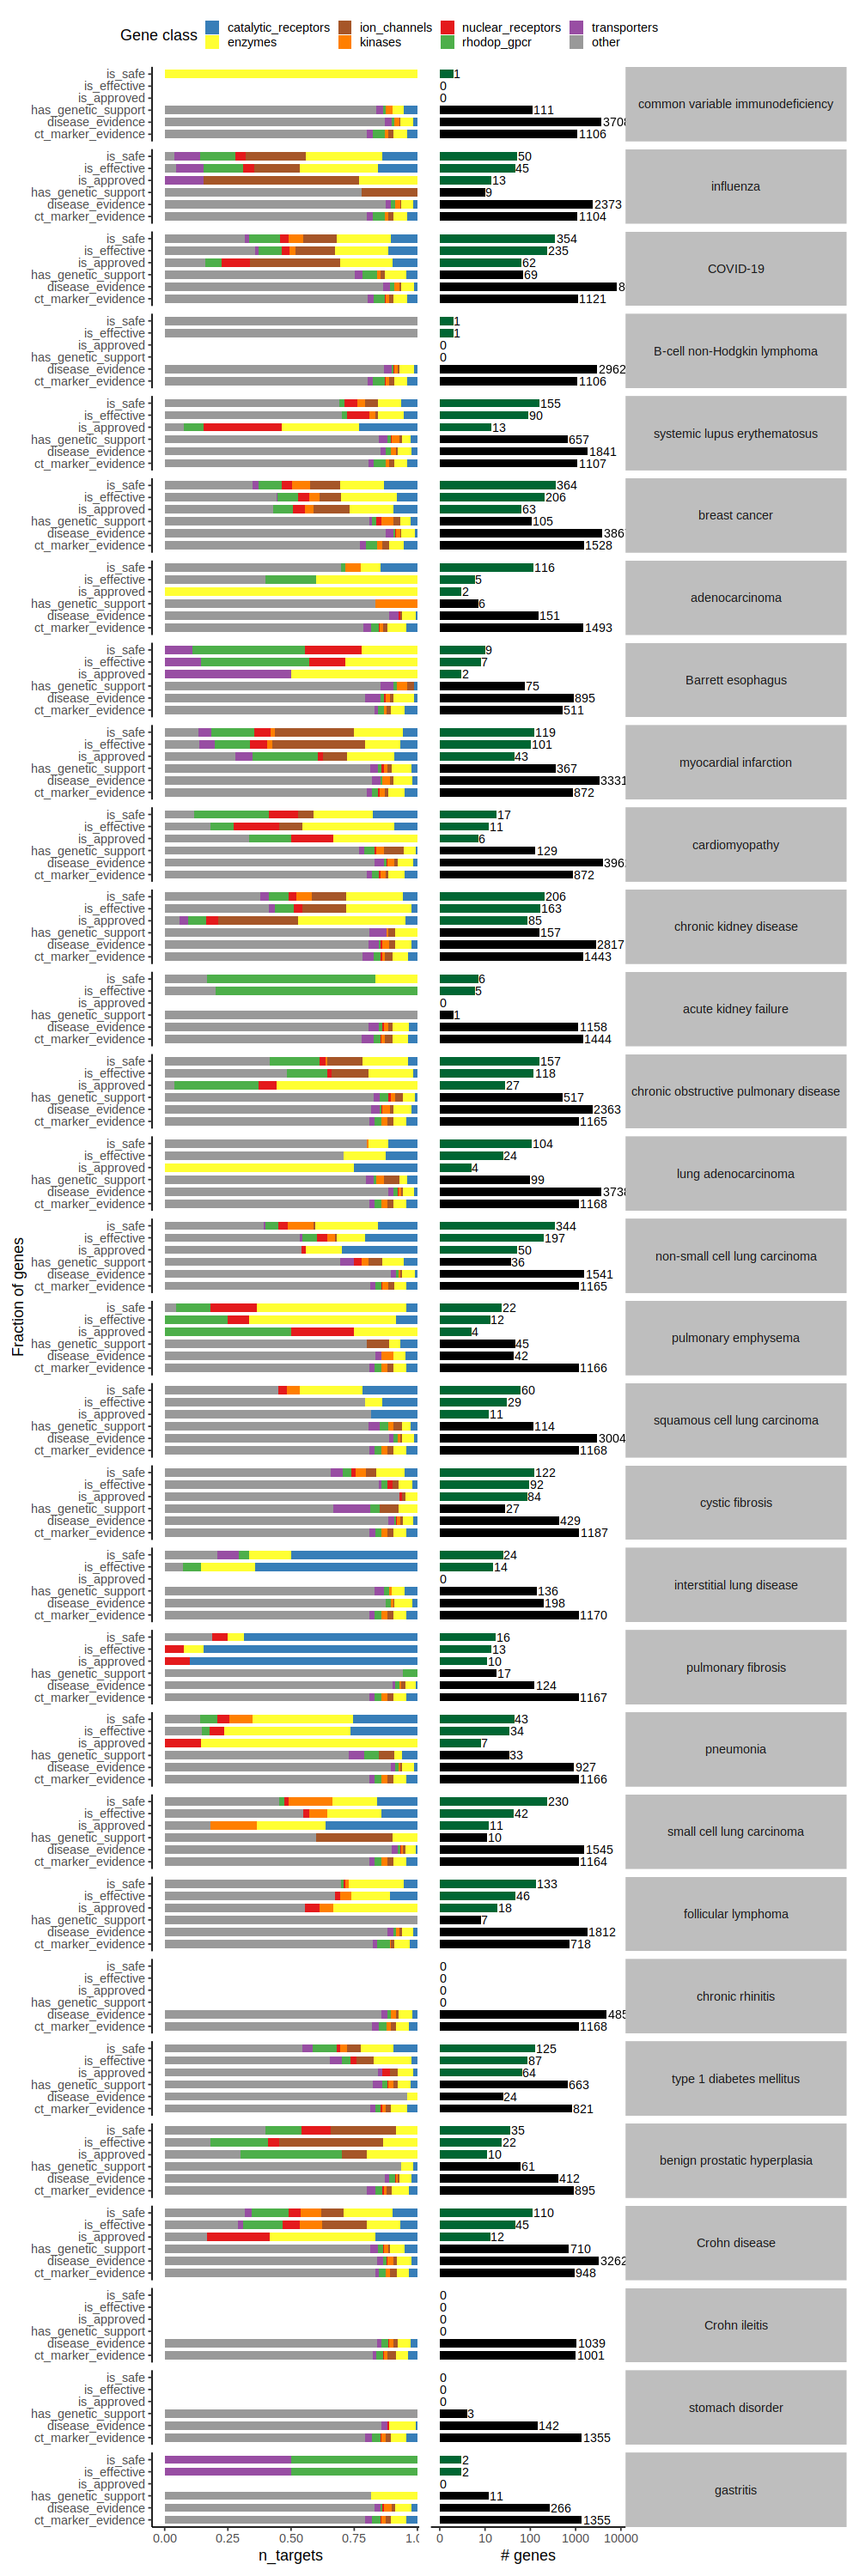

In [35]:
%%R -i pl_df -i disease_order -w 1000 -h 3000
df <- pl_df %>%
    mutate(gene_class= factor(gene_class, levels=c('catalytic_receptors', 'enzymes', 'ion_channels', 'kinases',
           'nuclear_receptors', 'rhodop_gpcr', 'transporters', 'other'))) %>%
    mutate(disease = factor(disease, levels=as.list(disease_order)))
    
pl2 <- df %>%
    mutate(gene_class= factor(gene_class, levels=c('catalytic_receptors', 'enzymes', 'ion_channels', 'kinases',
           'nuclear_receptors', 'rhodop_gpcr', 'transporters', 'other'))) %>%
    ggplot(aes(evidence, n_targets, fill=gene_class)) +
    geom_col(position='fill', width=0.7) +
    coord_flip() +
    scale_fill_manual(values=gene_class_palette, name='Gene class') +
    facet_grid(disease~.) +
    xlab('Fraction of genes') +
    theme_classic(base_size=18) +
    theme(
        strip.text.y = element_blank(), 
        legend.position='top',
        strip.background = element_blank())

pl1 <- df %>%
    group_by(disease, group, evidence) %>%
    summarise(n_targets=sum(n_targets)) %>%
    ggplot(aes(evidence, log10(n_targets+1), fill=group)) +
    geom_col(width=0.7) +
    geom_text(aes(label=n_targets), size=5, hjust=-0.05) +
    coord_flip() +
    scale_fill_manual(values=c(support='black', success='#006633')) +
    guides(fill='none') +
    ylim(0,5) +
    ylab('# genes') +
    scale_y_continuous(breaks=seq(0,4), label=c(0,10,100,1000,10000)) +
    facet_grid(disease~.) +
    theme_classic(base_size=18) +
    remove_y_axis() +
    theme(
        strip.text.y = element_text(angle=0), 
        axis.line.y = element_blank(),
        strip.background = element_rect(color=NA, fill='grey'))
    
(pl2 + plot_spacer() + pl1 ) +
    plot_layout(guides='collect', widths=c(1,-0.1, 0.7)) & (theme(legend.position='top')) 

# ggsave_figdir('targets_barplots_all', width=12, height=40)

In [57]:
pl_df = pl_df.groupby(['disease', 'evidence', 'group']).sum().reset_index()

/tmp/ipykernel_241/2370472211.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pl_df = pl_df.groupby(['disease', 'evidence', 'group']).sum().reset_index()


In [74]:
disease_order = targets_evidence_all.groupby(['disease']).sum().sort_values('is_approved').index

/tmp/ipykernel_241/3799720847.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  disease_order = targets_evidence_all.groupby(['disease']).sum().sort_values('is_approved').index


In [110]:
%%R -i pl_df -i disease_order -w 1500 -h 700
rename_labels <- c(
    "disease_evidence" = "Disease cell specific", 
    "ct_marker_evidence" = "Cell type specific", 
    "has_genetic_support" = "GWAS association",
    'is_approved' = 'Approved (> phase III)',
        'is_effective' = 'Effective (> phase II)',
        'is_safe' = 'Safe (> phase I)'
    )

pl_df %>%
    group_by(evidence) %>%
    mutate(evidence = factor(evidence, levels=c('is_approved', 'is_effective', 'is_safe', 'ct_marker_evidence', 'disease_evidence', 'has_genetic_support'))) %>%
    mutate(
        tot_targets = paste0('', sum(n_targets),' total G-D pairs'),
        mean = mean(n_targets)
          ) %>%
    mutate(evidence = factor(evidence, levels=unique(evidence))) %>%
    ungroup() %>%
    mutate(disease = factor(disease, levels=as.list(disease_order))) %>%
    
#     mutate(gene_class= factor(gene_class, levels=c('catalytic_receptors', 'enzymes', 'ion_channels', 'kinases',
#            'nuclear_receptors', 'rhodop_gpcr', 'transporters', 'other'))) %>%
#     filter(gene_class!='other' & group == 'support') %>%
    ggplot(aes(disease, n_targets, fill=group)) +
    geom_col(position='stack', width=0.7) +
    coord_flip(clip='off') +
    expand_limits(x=32) +
    geom_hline(data=. %>% distinct(evidence, mean, group), aes(yintercept=mean), linetype=2, color='grey20') +
    geom_text(data=. %>% distinct(evidence, mean, group, tot_targets), aes(x=31, y=1, label=tot_targets), size=4, hjust=0) +
    scale_fill_manual(values=gene_class_palette, name='Gene class') +
    facet_grid(.~evidence, scales='free_x', labeller=as_labeller(rename_labels)) +
    scale_fill_manual(values=c(support='black', success='#006633'), name='', labels= c(support='Omic support', success='clinical success')) +
    ylab('# genes') +
    theme_classic(base_size=18) +
    theme(
        legend.position='top',
        strip.background = element_rect(color=NA, fill='grey'))
    
ggsave_figdir('targets_barplots_all_noclass', width=17, height=9)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [32]:
targets_evidence_all.groupby(['disease_ontology_id', 'disease']).sum()[['ct_marker_evidence', 'disease_evidence']].mean()

/tmp/ipykernel_241/1476077415.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  targets_evidence_all.groupby(['disease_ontology_id', 'disease']).sum()[['ct_marker_evidence', 'disease_evidence']]


,,ct_marker_evidence,disease_evidence
disease_ontology_id,disease,,
MONDO_0000709,Crohn ileitis,1001.0,1039.0
MONDO_0002492,acute kidney failure,1444.0,1158.0
MONDO_0002771,pulmonary fibrosis,1167.0,124.0
MONDO_0004298,stomach disorder,1355.0,142.0
MONDO_0004514,chronic rhinitis,1168.0,4852.0
MONDO_0004849,pulmonary emphysema,1166.0,42.0
MONDO_0004966,gastritis,1355.0,266.0
MONDO_0004970,adenocarcinoma,1493.0,151.0
MONDO_0004994,cardiomyopathy,872.0,3962.0


In [31]:
targets_evidence_all.groupby(['disease_ontology_id', 'disease']).sum()[['is_safe', 'is_effective', 'is_approved']].mean()

/tmp/ipykernel_241/2193413857.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  targets_evidence_all.groupby(['disease_ontology_id', 'disease']).sum()[['is_safe', 'is_effective', 'is_approved']].mean()


is_safe         97.500000
is_effective    54.866667
is_approved     20.033333
dtype: float64

Compute odds-ratios for all diseases together with different universes

In [190]:
results_all_df = pd.DataFrame()
targets_evidence_all['all_sc_evidence'] = ((targets_evidence_all['disease_evidence'] == 1) & (targets_evidence_all['ct_marker_evidence'] == 1)).astype(int)

for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support', 'all_sc_evidence', 'is_hvg_normal', 'is_hvg_disease']:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['universe_size'] = len(u_list)
            results_all_df = pd.concat([results_all_df, or_df], axis=0)

In [192]:
OR_class_df = pd.DataFrame()
targets_evidence_all['all_sc_evidence'] = ((targets_evidence_all['disease_evidence'] == 1) & (targets_evidence_all['ct_marker_evidence'] == 1)).astype(int)

for u_name, u_list in annos_ensids.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in [ 'ct_marker_evidence', 'disease_evidence', 'has_genetic_support', 'all_sc_evidence']:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['universe_size'] = len(u_list)
            OR_class_df = pd.concat([OR_class_df, or_df], axis=0)

In [193]:
known_drug_targets_all = OT_targets_df[
    OT_targets_df['known_drug'] > 0.05 # reaching at least phase I
].gene_id.unique().tolist()

known_drug_or_df = pd.DataFrame()
for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in ['ct_marker_evidence', 'disease_evidence', 'all_sc_evidence','has_genetic_support']:
        ## All OT targets
        or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=known_drug_targets_all)
        or_df['universe'] = 'known_drug_targets'
        or_df['universe_size'] = len(known_drug_targets_all)
        known_drug_or_df = pd.concat([known_drug_or_df, or_df])

In [194]:
results_all_df = pd.concat([results_all_df, OR_class_df, known_drug_or_df])

In [33]:
## Save for supplementary figure
st_results_all_df = results_all_df[~results_all_df.evidence.isin(['is_hvg_normal', 'is_hvg_disease'])]
st_results_all_df.to_csv('../data/suppl_table_odds_ratios.all.csv')

Test within HVGs

In [173]:
hvgs_or_df = pd.DataFrame()
for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
    for ev in ['ct_marker_evidence', 'disease_evidence']:
        if ev == 'ct_marker_evidence':
            test_df = targets_evidence_all[targets_evidence_all.is_hvg_normal==1].copy()
        elif ev == 'disease_evidence':
            test_df = targets_evidence_all[targets_evidence_all.is_hvg_disease==1].copy()
        or_df = association_utils.get_OR(test_df, ev, ot_ev)
        or_df['universe'] = 'HVGs'
        hvgs_or_df = pd.concat([hvgs_or_df, or_df], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


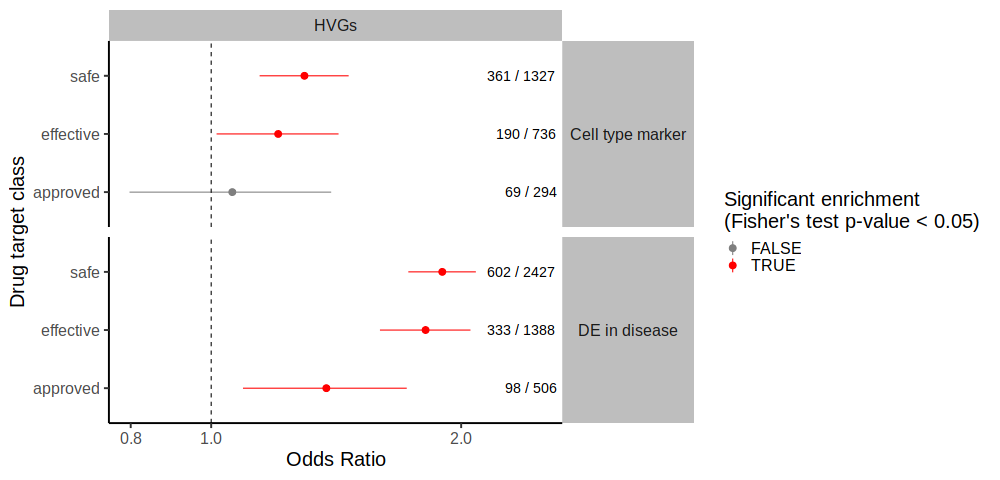

In [174]:
%%R -i hvgs_or_df -w 1000
plot_OR(hvgs_or_df, text_position='right') +
facet_grid(evidence~universe, scales='free_x',
           labeller = labeller(evidence=as_labeller(evidence_labels))
          )  +
expand_limits(x=2.5) +
ggsave_figdir('OR_HVGs', height=3, width=13)

## Plot intersection of universes

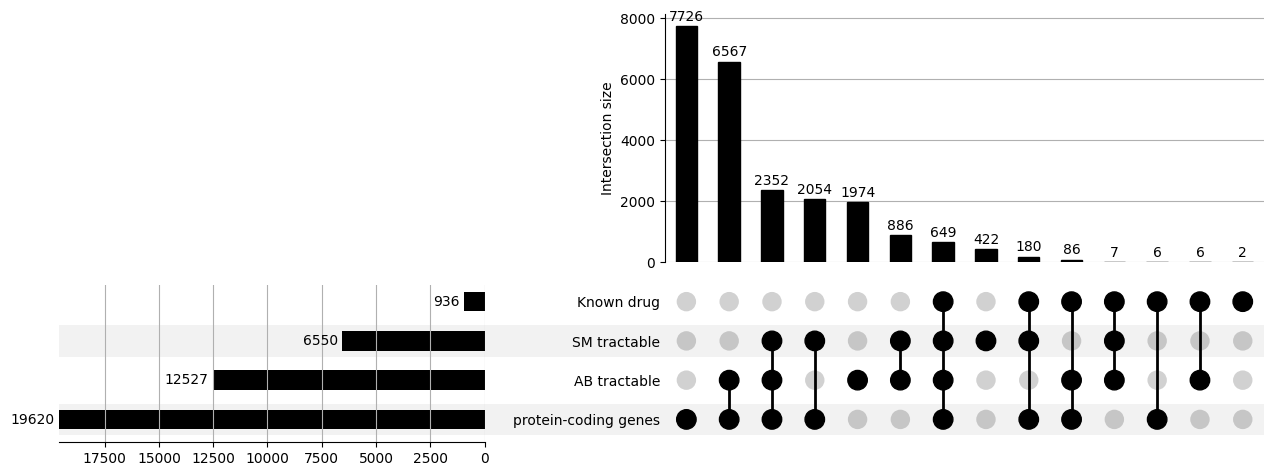

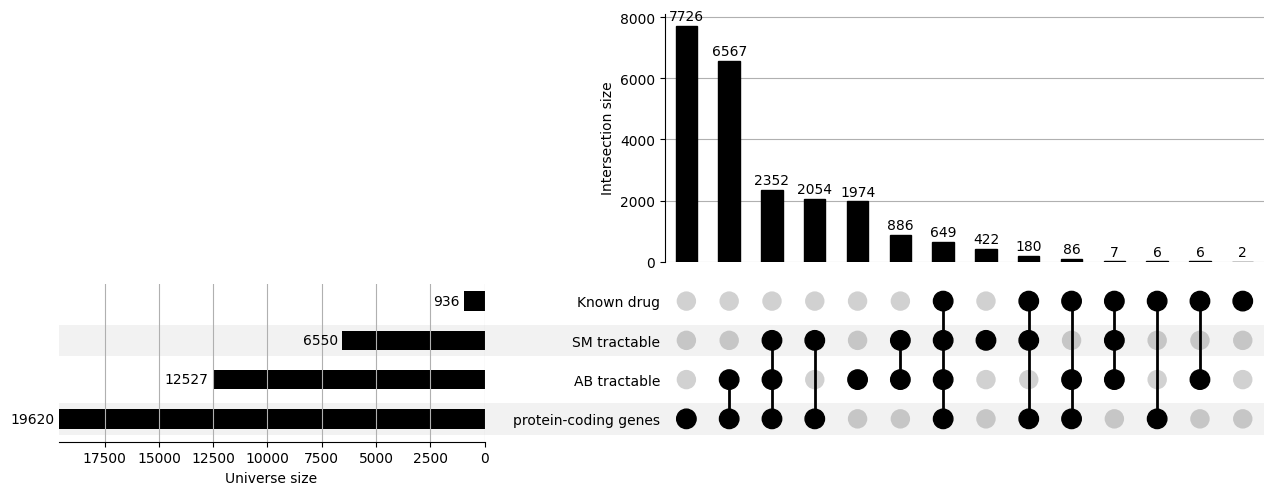

In [129]:
upset_dict = {'protein-coding genes':universe_dict['protein_coding_targets'],
    'SM tractable':universe_dict['sm_tractable_targets'],
    'AB tractable':universe_dict['ab_tractable_targets'],
     'Known drug':OT_targets_df[(OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())) & (OT_targets_df.known_drug > 0)].gene_id.unique().tolist()
#      'All OT targets': OT_targets_df[OT_targets_df['disease_ontology_id'].isin(targets_evidence_all.disease_ontology_id.unique())].gene_id.unique().tolist()
    }
# for k,v in annos_ensids.items():
#     upset_dict[k] = v
target_universe_upset = upsetplot.from_contents(upset_dict)

with plt.rc_context({'figure.figsize':[20,10]}):
    pl = upsetplot.UpSet(
        target_universe_upset, 
        orientation='horizontal', 
        show_counts = '{:d}', 
        sort_categories_by='cardinality',
        sort_by='cardinality',
        element_size=40,
        totals_plot_elements=10
    )
    plt_res = pl.plot()
    plt_res["totals"].set_xlabel("Universe size")
    plt.savefig(figdir + 'upset_gene_universe.png')
    plt.savefig(figdir + 'upset_gene_universe.pdf')

    plt.show()

## Plot Odds Ratio results

In [34]:
# %%R -i results_all_df -w 2500 -h 500 -i figdir
# pl_df <- 
#     filter(results_all_df, 
#                evidence %in% c('ct_marker_evidence', 'disease_evidence', 'has_genetic_support', 'all_sc_evidence'),
#            universe %in% c('protein_coding_targets', 'sm_tractable_targets',
#        'ab_tractable_targets','known_drug_targets')
#           ) %>%
#     mutate(universe = factor(universe, levels=c('protein_coding_targets', 'sm_tractable_targets',
#        'ab_tractable_targets','known_drug_targets'))) %>%
#     mutate(u_label = paste0(universe, '\n(', universe_size * 30, ' G-D pairs)'))

# uni_labeller <- distinct(pl_df, universe, u_label) 
# uni_labeller <- setNames(uni_labeller$u_label, uni_labeller$universe)

# plot_OR(pl_df, text_position='right', evidence_levels=c('ct_marker_evidence', 'disease_evidence', 'all_sc_evidence', 'has_genetic_support')) +
#     facet_grid(evidence~universe, scales='free_x',
#                labeller = labeller(
#                    evidence=as_labeller(evidence_labels),
#                    universe=as_labeller(uni_labeller)
#                )
#               ) +
#     expand_limits(x=60) +
#     ggsave(paste0(figdir, 'OR_results_all.png'), height=7, width=20) +
#     ggsave(paste0(figdir, 'OR_results_all.pdf'), height=7, width=20)

In [50]:
%%R -i results_all_df -w 2500 -h 500 -i figdir
pl_df <- 
    filter(results_all_df, 
               evidence %in% c('ct_marker_evidence', 'disease_evidence', 'has_genetic_support', 'all_sc_evidence'),
           universe %in% c('protein_coding_targets', 'sm_tractable_targets',
       'ab_tractable_targets','known_drug_targets')
          ) %>%
    mutate(universe = factor(universe, levels=c('protein_coding_targets', 'sm_tractable_targets',
       'ab_tractable_targets','known_drug_targets'))) %>%
    mutate(u_label = paste0(universe, '\n(', universe_size * 30, ' G-D pairs)')) %>%
    mutate(evidence = recode(evidence, !!!as.list(evidence_labels))) 
#     mutate(evidence = factor(evidence, levels=c("Cell type marker", "disease marker", "cell type & disease\nmarker","GWAS association")))

uni_labeller <- distinct(pl_df, universe, u_label) 
uni_labeller <- setNames(uni_labeller$u_label, uni_labeller$universe)

pl1 <- plot_OR(pl_df, y_value='evidence',
        text_position='right', 
        evidence_levels=rev(c("Cell type marker", "disease marker", "cell type & disease marker","GWAS association")),
        clinical_status_levels = c('druggable', 'safe', 'effective', 'approved'),
               base_font_size=22
       ) +
    facet_grid(clinical_status~universe, scales='free_x',
               labeller = labeller(
                   universe=as_labeller(uni_labeller)
               )
              ) +
    ylab("Omic support") +
    expand_limits(x=25) +
    ggsave(paste0(figdir, 'OR_results_all_v2.png'), height=6, width=22) +
    ggsave(paste0(figdir, 'OR_results_all_v2.pdf'), height=6, width=22)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


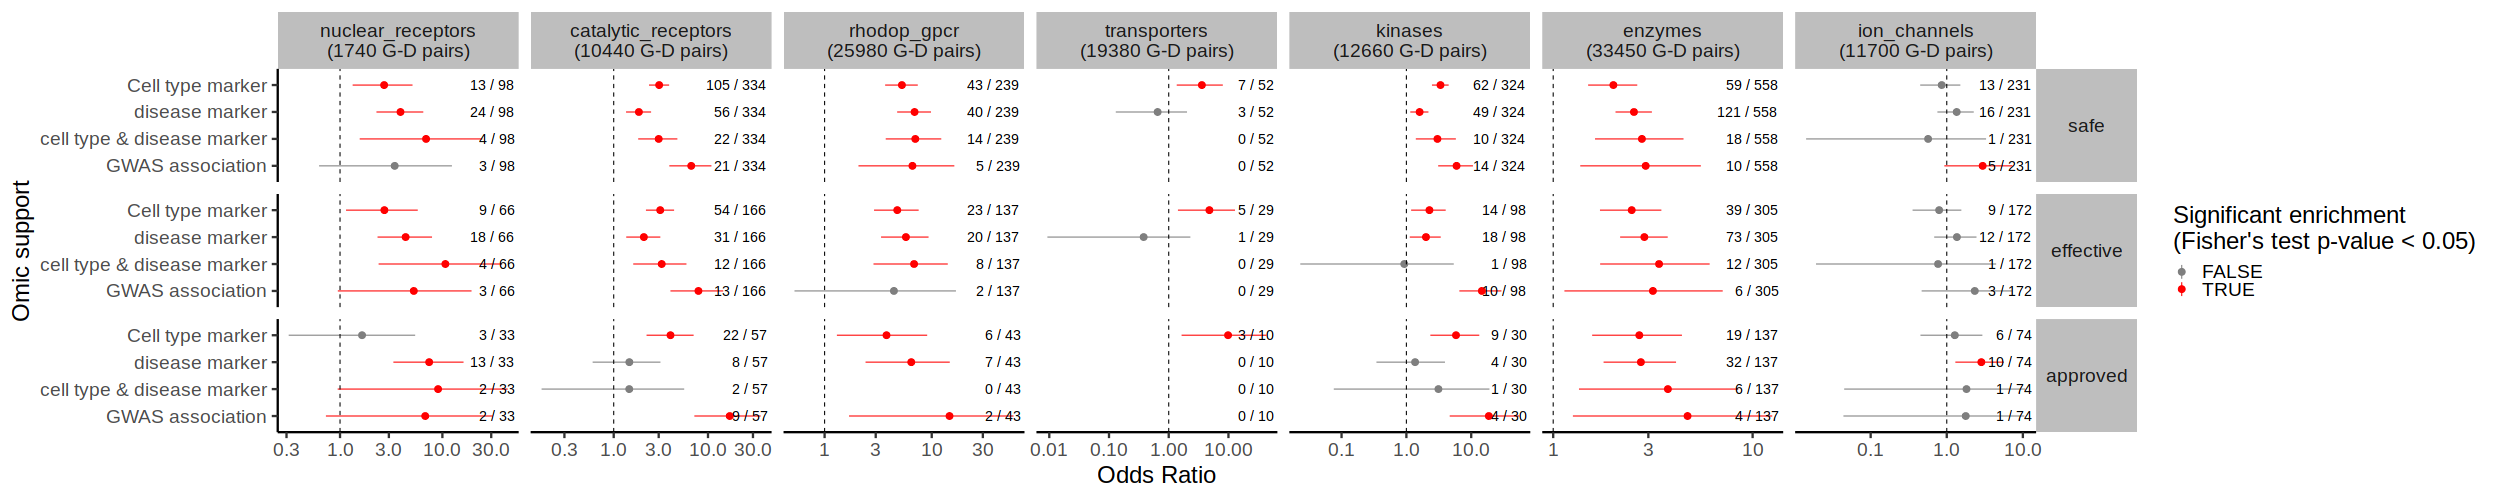

In [51]:
%%R -i results_all_df -w 2500 -h 500 -i figdir
pl_df <- 
    filter(results_all_df, 
               evidence %in% c('ct_marker_evidence', 'disease_evidence', 'has_genetic_support', 'all_sc_evidence'),
           universe %in% c('nuclear_receptors',
       'catalytic_receptors', 'rhodop_gpcr', 'transporters', 'kinases',
       'enzymes', 'ion_channels')
          ) %>%
    mutate(universe = factor(universe, levels=c('nuclear_receptors',
       'catalytic_receptors', 'rhodop_gpcr', 'transporters', 'kinases',
       'enzymes', 'ion_channels'))) %>%
    mutate(u_label = paste0(universe, '\n(', universe_size * 30, ' G-D pairs)')) %>%
        mutate(evidence = recode(evidence, !!!as.list(evidence_labels))) 

uni_labeller <- distinct(pl_df, universe, u_label) 
uni_labeller <- setNames(uni_labeller$u_label, uni_labeller$universe)

# plot_OR(pl_df, y_value='evidence',
#         text_position='right', 
#         evidence_levels=rev(c("Cell type marker", "disease marker", "GWAS association")),
#         clinical_status_levels = c('druggable', 'safe', 'effective', 'approved')
#        ) +
#     facet_grid(clinical_status~universe, scales='free_x',
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
#                )) +
#     expand_limits(x=25)
pl2 <- plot_OR(pl_df, 
               y_value='evidence',
        text_position='right', 
        evidence_levels=rev(c("Cell type marker", "disease marker", "cell type & disease marker","GWAS association")),
        clinical_status_levels = c('druggable', 'safe', 'effective', 'approved'),
        base_font_size=24) +
    facet_grid(clinical_status~universe, scales='free_x',
               labeller = labeller(
                   universe=as_labeller(uni_labeller)
               )) +
    ylab("Omic support") 
pl2 +
ggsave(paste0(figdir, 'OR_results_classes.png'), height=6, width=30) +
ggsave(paste0(figdir, 'OR_results_classes.pdf'), height=6, width=30)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


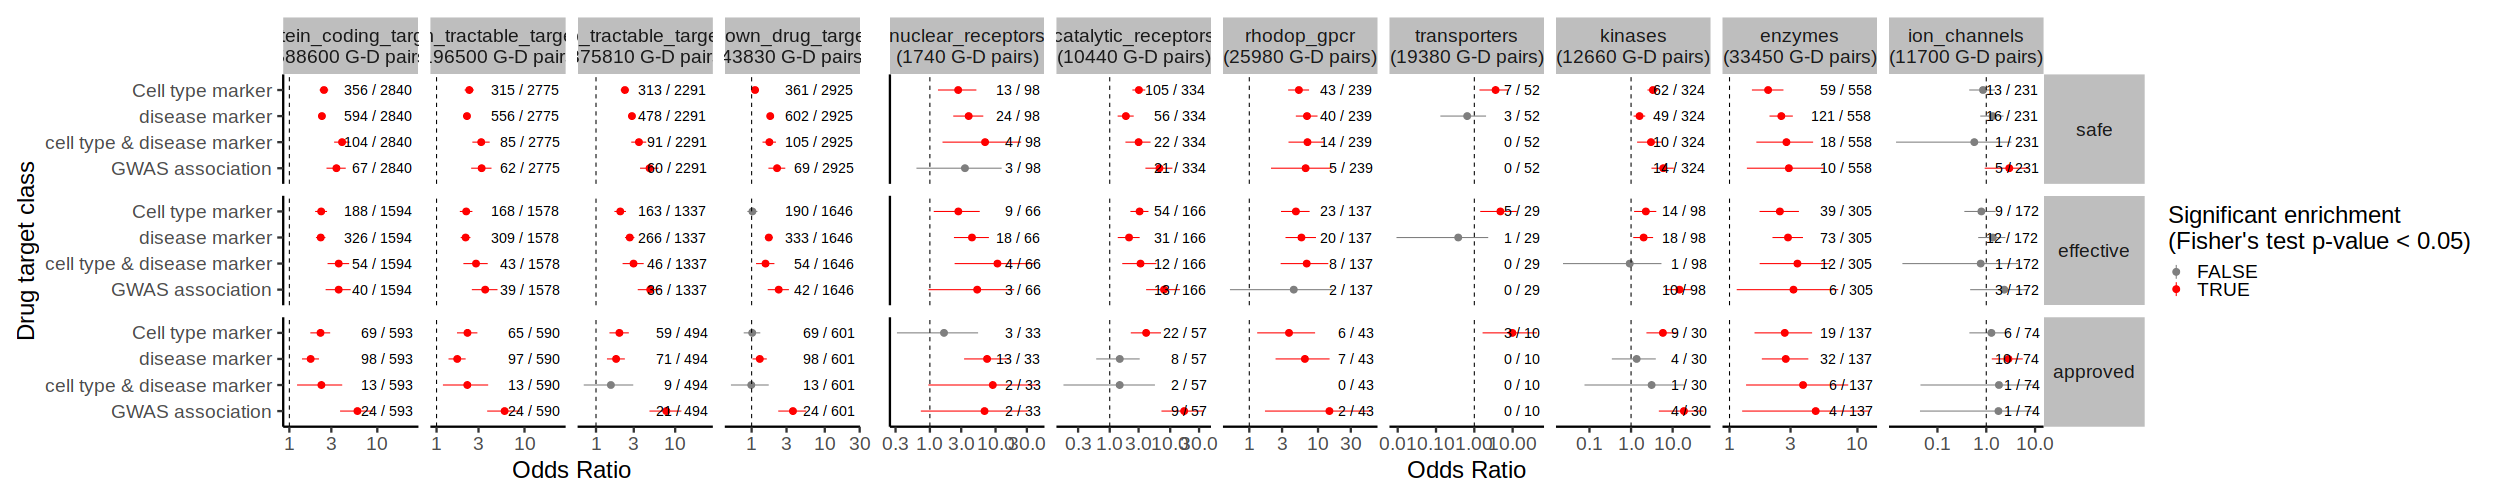

In [49]:
%%R -i results_all_df -w 2500 -h 500 
((pl1 + theme(strip.background.y = element_blank(), strip.text.y=element_blank())) + (pl2 + remove_y_axis())) + plot_layout(guides='collect', widths=c(1,2))

Check difference in evolutionary constraint on these classes of genes.

In [111]:
# gene_table = pd.read_table("/home/jovyan/gene_annots/pc_genes.txt")
gene_table = pd.read_table("../data/gnomad.v2.1.1.lof_metrics.by_gene.txt")
loeuf_table = gene_table[['gene_id', 'oe_lof', 'gene']]
loeuf_table = loeuf_table.rename({'oe_lof':'LOEUF'}, axis=1)

annos_df = pd.DataFrame([(k,x) for k,v in annos.items() for x in v])
annos_df.columns = ['gene_class', 'gene']
annos_table = loeuf_table[loeuf_table.gene_id.isin(np.hstack(annos_ensids.values()))][['gene_id', 'LOEUF', 'gene']]
annos_table = pd.merge(annos_table, annos_df)
# annos_table = annos_table[annos_table['LOEUF'] < 6].copy()

/tmp/ipykernel_597/4090552739.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  annos_table = loeuf_table[loeuf_table.gene_id.isin(np.hstack(annos_ensids.values()))][['gene_id', 'LOEUF', 'gene']]


In [115]:
sum(annos_table['LOEUF'] > 3)

2

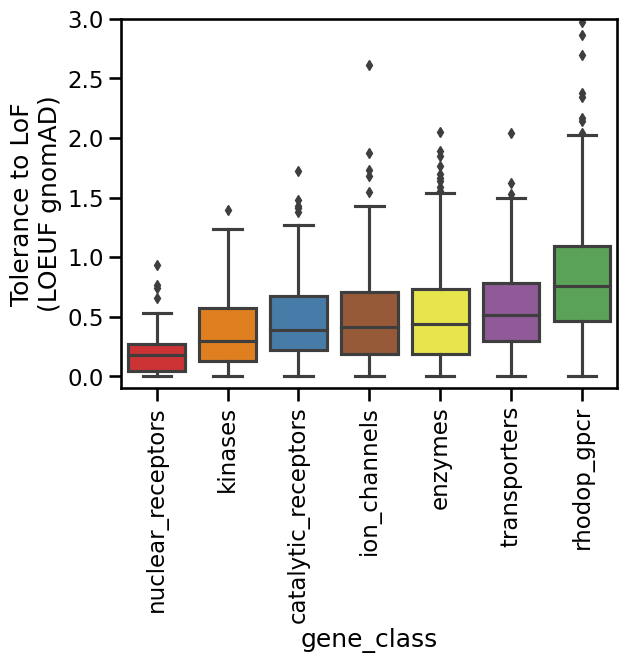

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk');
mean_pLI_order = annos_table.groupby('gene_class')['LOEUF'].mean().sort_values().index

sns.boxplot(data=annos_table, x='gene_class', y='LOEUF', 
#             scale='width', cut=True, 
            order=mean_pLI_order, palette=gene_class_palette)
plt.ylabel('Tolerance to LoF\n(LOEUF gnomAD)');
plt.ylim(-0.1,3);
plt.xticks(rotation=90)

plt.savefig(figdir + 'gene_classes_LOEUF.pdf');
plt.savefig(figdir + 'gene_classes_LOEUF.png')

In [206]:
mean_LOEUF = annos_table.groupby('gene_class').mean().reset_index()
mean_LOEUF = mean_LOEUF.rename({'gene_class':'universe'}, axis=1)

/tmp/ipykernel_231/1647893220.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_LOEUF = annos_table.groupby('gene_class').mean().reset_index()


In [221]:
df = pd.merge(results_all_df, mean_LOEUF, how='left')
df = df[df.universe.isin(mean_LOEUF.universe) & (df.clinical_status == 'is_safe')].copy()

In [249]:
class_all_df = pd.DataFrame()
targets_evidence_all['all_sc_evidence'] = ((targets_evidence_all['disease_evidence'] == 1) & (targets_evidence_all['ct_marker_evidence'] == 1)).astype(int)

for ot_ev in ["is_" + x for x in annos.keys()]:
    for ev in ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']:
        or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=universe_dict['protein_coding_targets'])
        class_all_df = pd.concat([class_all_df, or_df], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


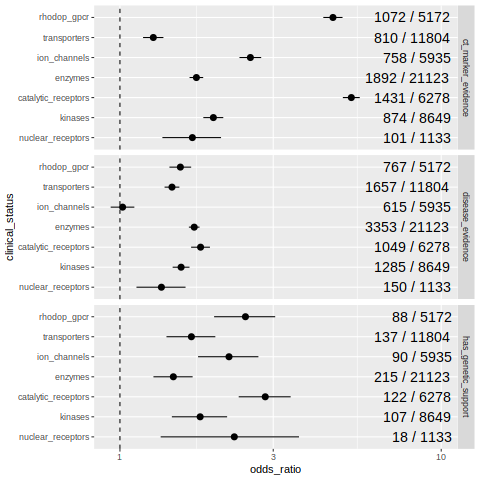

In [259]:
%%R -i class_all_df -i mean_pLI_order

class_all_df %>%
    mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=mean_pLI_order)) %>%
    ggplot(aes(odds_ratio, clinical_status)) +
    geom_point() +
    geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                        aes(xmin=ci_low, xmax=ci_high)) +
        geom_text(aes(label = paste0(n_supported_approved,' / ', n_success)), 
                  x = ifelse(text_position == 'right', Inf, -Inf) , 
                  hjust= ifelse(text_position == 'right', 1.1, -1) , 
                  size=5,
                  color='black',) +
        geom_vline(xintercept=1, linetype=2) +
        scale_x_log10() +
        expand_limits(x=10) +
    facet_grid(evidence~.)

In [363]:
# df = targets_evidence_all[targets_evidence_all['is_safe'] == 1].groupby('gene_class').sum()[evidence_cols + ['has_genetic_support']].reset_index()
df = targets_evidence_all[targets_evidence_all['is_safe'] == 1].groupby('gene_class').sum()[['ct_marker_evidence', 'disease_evidence','has_genetic_support', 'is_safe']].reset_index()
df = df.melt(id_vars=['gene_class'], var_name='evidence')

/tmp/ipykernel_231/1827974228.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = targets_evidence_all[targets_evidence_all['is_safe'] == 1].groupby('gene_class').sum()[['ct_marker_evidence', 'disease_evidence','has_genetic_support', 'is_safe']].reset_index()


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


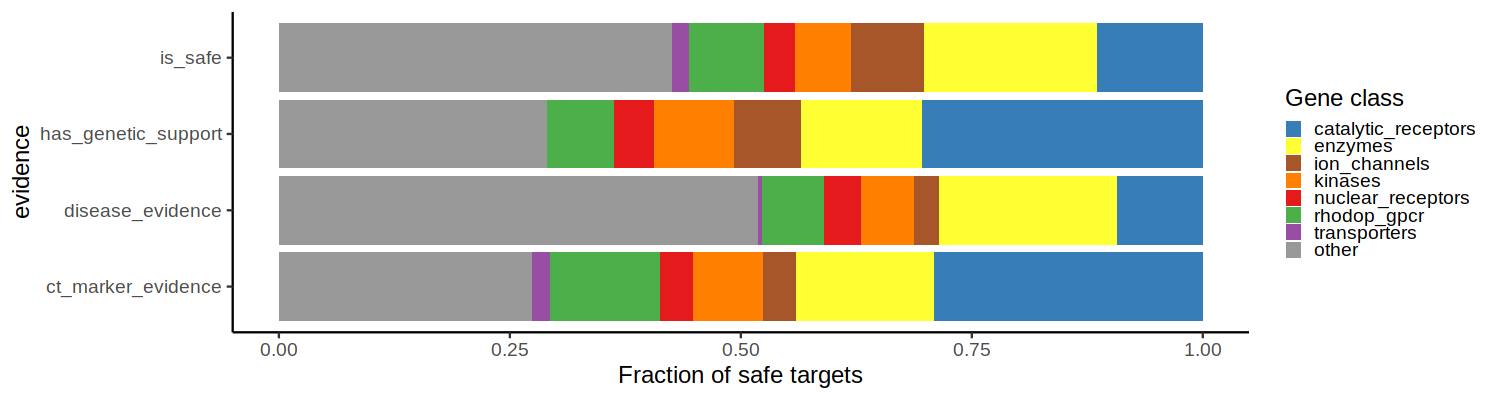

In [364]:
%%R -i df -w 1500 -h 400
df %>%
group_by(evidence) %>%
# mutate(tot_ev = sum(value)) %>%
# mutate(value = (value/tot_ev) * 100) %>%
mutate(gene_class= factor(gene_class, levels=c('catalytic_receptors', 'enzymes', 'ion_channels', 'kinases',
           'nuclear_receptors', 'rhodop_gpcr', 'transporters', 'other'))) %>%
ggplot(aes(evidence, fill=gene_class, y=value)) +
geom_col(position='fill') +
coord_flip() +
scale_fill_manual(values=gene_class_palette, name='Gene class') +
ylab('Fraction of safe targets') +
theme_classic(base_size=24) 

In [333]:
df = pd.merge(gene_table[['GeneSymbol', 'LOEUF']].rename({'GeneSymbol':'gene_id'}, axis=1), targets_evidence_all)
ev_df_all = pd.DataFrame()
for ev in ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']:
    ev_df = df[df[ev] == 1][['gene_id', 'LOEUF']].drop_duplicates().dropna()
    ev_df['evidence'] = ev
    ev_df_all = pd.concat([ev_df_all, ev_df])

# scipy.stats.ttest_ind(
#     df[df.has_genetic_support == 1][['gene_id', 'LOEUF']].drop_duplicates().dropna().LOEUF,
#     df[df.ct_marker_evidence == 1][['gene_id', 'LOEUF']].drop_duplicates().dropna().LOEUF,
#     alternative='less'
#     )

<AxesSubplot: xlabel='evidence', ylabel='LOEUF'>

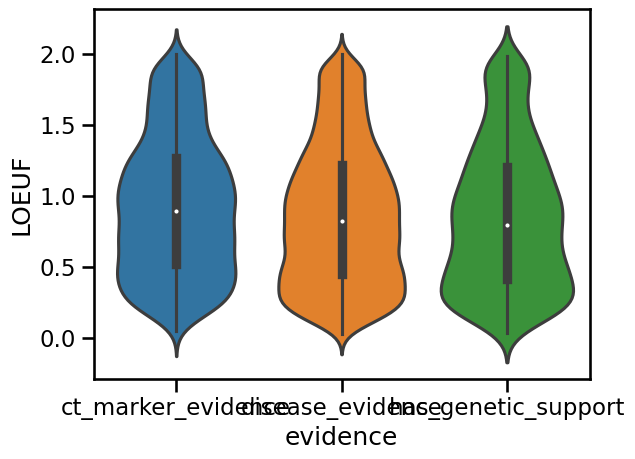

In [335]:
sns.violinplot(data=ev_df_all, x='evidence', y='LOEUF')

In [246]:
targets_evidence_all[targets_evidence_all['ct_marker_evidence'] == 1].value_counts('gene_class') / targets_evidence_all['ct_marker_evidence'].sum()

gene_class
other                  0.803411
enzymes                0.055298
catalytic_receptors    0.042521
rhodop_gpcr            0.031854
transporters           0.024068
ion_channels           0.022523
kinases                0.017323
nuclear_receptors      0.003001
dtype: float64

In [247]:
targets_evidence_all[targets_evidence_all['disease_evidence'] == 1].value_counts('gene_class') / targets_evidence_all['disease_evidence'].sum()

gene_class
other                  0.857406
enzymes                0.054757
transporters           0.027313
kinases                0.018110
catalytic_receptors    0.017239
rhodop_gpcr            0.012605
ion_channels           0.010107
nuclear_receptors      0.002465
dtype: float64

## Test combination of types of support

In [73]:
if targets_evidence_all.columns.str.contains("_AND_").any():
    targets_evidence_all.drop(targets_evidence_all.columns[targets_evidence_all.columns.str.contains("_AND_")], axis=1, inplace=True)
    targets_evidence_all.drop(targets_evidence_all.columns[targets_evidence_all.columns.str.contains("_OR_")], axis=1, inplace=True)

evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'all_sc_evidence']
for ev1 in evidence_cols:
    for ev2 in evidence_cols:
        targets_evidence_all[f'has_genetic_support_AND_{ev2}'] = ((targets_evidence_all['has_genetic_support'] == 1) & (targets_evidence_all[ev2] == 1)).astype(int)
        targets_evidence_all[f'has_genetic_support_OR_{ev2}'] = ((targets_evidence_all['has_genetic_support'] == 1) | (targets_evidence_all[ev2] == 1)).astype(int)

In [76]:
combo_evidence_cols = ['all_sc_evidence', 'has_genetic_support'] + [x for x in targets_evidence_all.columns if '_AND_' in x] + [x for x in targets_evidence_all.columns if '_OR_' in x]
results_combo_df = pd.DataFrame()

# Large universe
for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in combo_evidence_cols:
            or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            results_combo_df = pd.concat([results_combo_df, or_df], axis=0)

# # gene classes
# for u_name, u_list in annos_ensids.items():
#     for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
#         for ev in combo_evidence_cols:
#             or_df = association_utils.get_OR(targets_evidence_all, ev, ot_ev, gene_universe=u_list)
#             or_df['universe'] = u_name
#             results_combo_df = pd.concat([results_combo_df, or_df], axis=0)

In [77]:
results_combo_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe
0,3.973090,3.228791,4.842749,8.344439e-30,2840.0,585760.0,104.0,5655.0,all_sc_evidence,is_safe,protein_coding_targets
0,3.427745,2.643661,4.376804,7.886609e-17,2840.0,585760.0,67.0,4167.0,has_genetic_support,is_safe,protein_coding_targets
0,4.040363,1.611311,8.422065,2.197998e-03,2840.0,585760.0,7.0,365.0,has_genetic_support_AND_ct_marker_evidence,is_safe,protein_coding_targets
0,3.431408,1.702643,6.189354,5.388188e-04,2840.0,585760.0,11.0,674.0,has_genetic_support_AND_disease_evidence,is_safe,protein_coding_targets
0,0.000000,0.000000,7.675930,1.000000e+00,2840.0,585760.0,0.0,101.0,has_genetic_support_AND_all_sc_evidence,is_safe,protein_coding_targets
...,...,...,...,...,...,...,...,...,...,...,...
0,4.042785,0.486456,14.783001,8.947968e-02,494.0,375316.0,2.0,379.0,has_genetic_support_AND_disease_evidence,is_approved,ab_tractable_targets
0,0.000000,0.000000,40.655309,1.000000e+00,494.0,375316.0,0.0,71.0,has_genetic_support_AND_all_sc_evidence,is_approved,ab_tractable_targets
0,2.518472,1.950804,3.215446,1.251147e-11,494.0,375316.0,78.0,26084.0,has_genetic_support_OR_ct_marker_evidence,is_approved,ab_tractable_targets
0,2.246798,1.767099,2.830710,1.432982e-10,494.0,375316.0,90.0,33946.0,has_genetic_support_OR_disease_evidence,is_approved,ab_tractable_targets


In [78]:
results_combo_df = pd.concat([results_combo_df, results_combo_df['evidence'].str.split("_AND_|_OR_", expand=True)], axis=1).rename({0:'ev1', 1:'ev2'}, axis=1)
results_combo_df['operation'] = np.where(results_combo_df.evidence.str.contains('AND'), 'AND', np.where(results_combo_df.evidence.str.contains('OR'), 'OR', 'single'))

In [62]:
# results_combo_df = results_combo_df[results_combo_df['operation'] != 'single'].copy()

In [123]:
pl_evidences = [
    'all_sc_evidence',
    'has_genetic_support',
    'has_genetic_support_AND_ct_marker_evidence',
    'has_genetic_support_AND_disease_evidence'
]

results_combo_df = results_combo_df[results_combo_df['evidence'].isin(pl_evidences)].copy()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


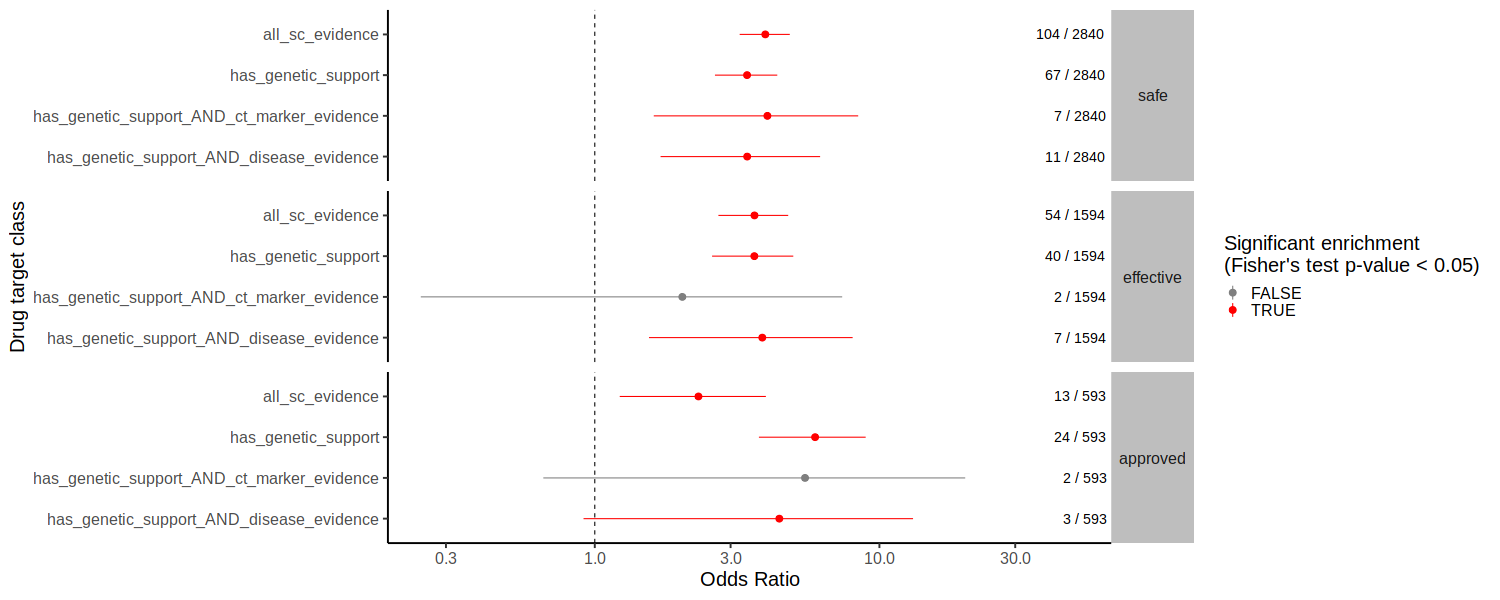

In [128]:
%%R -i results_combo_df -i pl_evidences -w 1500 -h 600

filter(results_combo_df, universe == 'protein_coding_targets')
plot_OR(filter(results_combo_df, universe == 'protein_coding_targets'), 
        y_value='evidence', 
        evidence_levels = rev(pl_evidences), 
        clinical_status_levels=c('druggable', 'safe', 'effective', 'approved')) +
    facet_grid(clinical_status~.) +
    expand_limits(x=50) +
    ggsave_figdir('OR_combo_figure', height=8, width=15)

### Overlap between evidence sets

In [101]:
def _get_frac_supported(drug_target_evidence, ev_col, success_col):
    n_supported = sum((drug_target_evidence[ev_col]==1) & (drug_target_evidence[success_col]==1))
    n_total = sum(drug_target_evidence[success_col]==1)
    print(f'{success_col} - supported by {ev_col} {(np.round(n_supported/n_total, 5)) * 100}% ({n_supported} / {n_total})')

drug_target_evidence = targets_evidence_all[targets_evidence_all['is_druggable'] == 1]
drug_target_evidence['any_sc_evidence'] = ((drug_target_evidence['disease_evidence'] == 1) | (drug_target_evidence['ct_marker_evidence'] == 1)).astype(int)

print("--- Genetic support ---")
_get_frac_supported(drug_target_evidence, 'has_genetic_support', 'is_druggable')
_get_frac_supported(drug_target_evidence, 'has_genetic_support', 'is_safe')
_get_frac_supported(drug_target_evidence, 'has_genetic_support', 'is_effective')
_get_frac_supported(drug_target_evidence, 'has_genetic_support', 'is_approved')
print("--- scRNA-seq support ---")
_get_frac_supported(drug_target_evidence, 'any_sc_evidence', 'is_druggable')
_get_frac_supported(drug_target_evidence, 'any_sc_evidence', 'is_safe')
_get_frac_supported(drug_target_evidence, 'any_sc_evidence', 'is_effective')
_get_frac_supported(drug_target_evidence, 'any_sc_evidence', 'is_approved')
_get_frac_supported(drug_target_evidence, 'all_sc_evidence', 'is_druggable')
_get_frac_supported(drug_target_evidence, 'all_sc_evidence', 'is_safe')
_get_frac_supported(drug_target_evidence, 'all_sc_evidence', 'is_effective')
_get_frac_supported(drug_target_evidence, 'all_sc_evidence', 'is_approved')
_get_frac_supported(drug_target_evidence, 'ct_marker_evidence', 'is_safe')
_get_frac_supported(drug_target_evidence, 'ct_marker_evidence', 'is_effective')
_get_frac_supported(drug_target_evidence, 'ct_marker_evidence', 'is_approved')
_get_frac_supported(drug_target_evidence, 'disease_evidence', 'is_safe')
_get_frac_supported(drug_target_evidence, 'disease_evidence', 'is_effective')
_get_frac_supported(drug_target_evidence, 'disease_evidence', 'is_approved')


--- Genetic support ---
is_druggable - supported by has_genetic_support 2.186% (77 / 3522)
is_safe - supported by has_genetic_support 2.359% (69 / 2925)
is_effective - supported by has_genetic_support 2.552% (42 / 1646)
is_approved - supported by has_genetic_support 3.993% (24 / 601)
--- scRNA-seq support ---
is_druggable - supported by any_sc_evidence 28.535% (1005 / 3522)
is_safe - supported by any_sc_evidence 29.333% (858 / 2925)
is_effective - supported by any_sc_evidence 28.493000000000002% (469 / 1646)
is_approved - supported by any_sc_evidence 25.624000000000002% (154 / 601)
is_druggable - supported by all_sc_evidence 3.6630000000000003% (129 / 3522)
is_safe - supported by all_sc_evidence 3.5900000000000003% (105 / 2925)
is_effective - supported by all_sc_evidence 3.2809999999999997% (54 / 1646)
is_approved - supported by all_sc_evidence 2.163% (13 / 601)
is_safe - supported by ct_marker_evidence 12.342% (361 / 2925)
is_effective - supported by ct_marker_evidence 11.543000000000

/tmp/ipykernel_230/3148567296.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_target_evidence['any_sc_evidence'] = ((drug_target_evidence['disease_evidence'] == 1) | (drug_target_evidence['ct_marker_evidence'] == 1)).astype(int)


In [ ]:
_get_frac_supported(drug_target_evidence[drug_target_evidence.], 'all_sc_evidence', 'is_safe')

In [1064]:
targets_evidence_all['target_disease'] = targets_evidence_all['gene_id'] + "_" + targets_evidence_all['disease_ontology_id']
evidence_cols = ['ct_marker_evidence', 'disease_evidence', 'has_genetic_support']

for col in ['is_safe', 'is_effective', 'is_approved']:
    evidence_sets_dict = {}
    for ev in evidence_cols:
        evidence_sets_dict[ev] = targets_evidence_all.target_disease[
            (targets_evidence_all[ev] == 1)
            & (targets_evidence_all[col] == 1)
        ].tolist()

    evidence_upset = upsetplot.from_contents(evidence_sets_dict)

    pl = upsetplot.UpSet(
        evidence_upset, 
        orientation='horizontal', 
        show_counts = '{:d}', 
        sort_categories_by='cardinality',
        sort_by='cardinality',
        intersection_plot_elements=3
    )

    pl.plot()
    plt.savefig(figdir + f'upset_evidence_{col}.pdf')
    plt.savefig(figdir + f'upset_evidence_{col}.png')

In [27]:
targets_evidence_all[(targets_evidence_all['has_genetic_support'] == 1) & (targets_evidence_all.ct_marker_evidence==1) & (targets_evidence_all.is_safe==1)]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,gene_id,disease_ontology_id,genetic_association,known_drug,is_druggable,is_safe,is_effective,...,gene_name,is_nuclear_receptors,is_catalytic_receptors,is_rhodop_gpcr,is_transporters,is_kinases,is_enzymes,is_ion_channels,gene_class,all_sc_evidence
58067,58067,58067,58067,ENSG00000232810,MONDO_0005011,0.068668,0.990551,1.0,1.0,1.0,...,TNF,0,0,0,0,0,0,0,other,0
262533,262533,262533,262533,ENSG00000066468,MONDO_0007254,0.637954,0.189174,1.0,1.0,0.0,...,FGFR2,0,1,0,0,1,0,0,catalytic_receptors,0
362102,362102,362102,362102,ENSG00000151617,MONDO_0005002,0.529119,0.121586,1.0,1.0,0.0,...,EDNRA,0,0,1,0,0,0,0,rhodop_gpcr,0
391298,391298,391298,391298,ENSG00000072694,MONDO_0007915,0.511125,0.121586,1.0,1.0,0.0,...,FCGR2B,0,0,0,0,0,0,0,other,0
391343,391343,391343,391343,ENSG00000101017,MONDO_0007915,0.374120,0.121586,1.0,1.0,0.0,...,CD40,0,1,0,0,0,0,0,catalytic_receptors,0
391474,391474,391474,391474,ENSG00000121594,MONDO_0007915,0.558075,0.169292,1.0,1.0,0.0,...,CD80,0,0,0,0,0,0,0,other,0
391916,391916,391916,391916,ENSG00000196664,MONDO_0007915,0.786693,0.844516,1.0,1.0,1.0,...,TLR7,0,1,0,0,0,0,0,catalytic_receptors,0


## Compare types of disease cell specific genes

Up vs down-regulation, tissue-level vs cell type level 

In [213]:
def _parse_DE_in_disease(
    disease_ontology_id, 
    OT_targets_df,
    signif_thresh = 0.01,
    lfc_thresh=0.5,
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    '''Parse DE outputs for each disease and merge with OT clinical status and genetic evidence.
    
    Params
    ------
    disease_ontology_id
        Disease MONDO ID
    OT_targets_df
        Dataframe of OpenTargets target-disease pairs
    signif_thresh
        Threshold for DE adjusted p-value
    lfc_thresh
        parameters passed to `DE2evidence_disease_params`
    data_dir 
        path to directory storing DE results
        
    Returns
    -------
    targets_disease_df
        DataFrame of target-disease pairs with clinical status and omics evidence.
    '''
    disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    bulk_res = pd.read_csv(f'{data_dir}/DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

    evidence_dict = {}
    for gr in ['positive', 'negative']:
        disease_evidence = sc_evidence_utils.DE2evidence_disease(
            disease_res, bulk_res,  signif_thresh=signif_thresh, lfc_thresh=lfc_thresh, lfc_group=gr)
        disease_evidence['disease_bulk_evidence'] = np.intersect1d(disease_evidence['bulk_disease_evidence'], disease_evidence['disease_evidence'])        
        disease_evidence_new = {f'{k}_{gr}': v for k, v in disease_evidence.items()}
        evidence_dict.update(disease_evidence_new)

    # Make target-disease table for sc evidence
    targets_disease_df = pd.DataFrame()
    targets_disease_df['gene_id'] = np.unique(np.hstack([x for x in evidence_dict.values()])) # Get all targets with sc evidence
    targets_disease_df['disease_ontology_id'] = disease_ontology_id

    for ev,targets in evidence_dict.items():
        targets_disease_df[ev] = targets_disease_df.gene_id.isin(targets).astype(int)
    
    # Merge with Open Targets clinical status and genetic evidence
    OT_targets_disease_df = OT_targets_df[
        (OT_targets_df['disease_ontology_id'] == disease_ontology_id) & \
        ((OT_targets_df['known_drug'] > 0) | (OT_targets_df['has_genetic_support'] > 0)) 
    ].copy()

    targets_disease_df = pd.merge(OT_targets_disease_df, targets_disease_df, how='outer').fillna(0)
    return(targets_disease_df)

In [ ]:
targets_evidence_disease = pd.DataFrame()
for disease_ontology_id in all_disease_ids:
    try:
        targets_disease_df = _parse_DE_in_disease(
            disease_ontology_id, 
            OT_targets_df,
            signif_thresh = 0.01,
            lfc_thresh = 0.5
        )
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
    targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
    targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
    targets_evidence_disease = pd.concat([targets_evidence_disease, targets_disease_df], axis=0)


In [309]:
# targets_evidence_disease = pd.merge(targets_evidence_disease, ens_ids_to_name, how='left')
# for k,a in annos.items():
#     targets_evidence_disease[f'is_{k}'] = targets_evidence_disease.gene_name.isin(a).astype('int')

# gene_group_cols = [f'is_{k}' for k in annos.keys()]
# targets_evidence_disease['gene_class'] = np.where(
#     targets_evidence_disease[gene_group_cols].sum(1) > 0,
#     targets_evidence_disease[gene_group_cols].idxmax(axis=1).str.replace('is_', ''),
#     'other'
#         )

In [211]:
evidence_cols = ['bulk_disease_evidence_positive',
       'disease_evidence_positive', 'disease_ct_evidence_positive', 'disease_bulk_evidence_positive',
       'bulk_disease_evidence_negative', 'disease_evidence_negative',
       'disease_ct_evidence_negative', 'disease_bulk_evidence_negative']

In [214]:
results_disease_df = pd.DataFrame()
for u_name, u_list in universe_dict.items():
    for ot_ev in ['is_safe', 'is_effective', 'is_approved']:
        for ev in evidence_cols:
            or_df = association_utils.get_OR(targets_evidence_disease, ev, ot_ev, gene_universe=u_list)
            or_df['universe'] = u_name
            or_df['universe_size'] = len(u_list)
            results_disease_df = pd.concat([results_disease_df, or_df], axis=0)

results_disease_df['DE_sign'] = [x[-1] for x in results_disease_df['evidence'].str.split('_')]
# results_disease_df['evidence'] = results_disease_df['evidence'].str.replace("_positive", '').str.replace("_negative", '')

In [215]:
results_disease_df[results_disease_df.universe == 'protein_coding_targets']

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe,universe_size,DE_sign
0,2.393389,2.065258,2.761177,9.919610e-27,2840.0,585760.0,206.0,18741.0,bulk_disease_evidence_positive,is_safe,protein_coding_targets,19620,positive
0,2.344857,2.137662,2.569004,4.434180e-64,2840.0,585760.0,594.0,59964.0,disease_evidence_positive,is_safe,protein_coding_targets,19620,positive
0,2.185618,1.969396,2.421154,3.389423e-43,2840.0,585760.0,442.0,45999.0,disease_ct_evidence_positive,is_safe,protein_coding_targets,19620,positive
0,2.341430,1.973487,2.760471,1.342790e-19,2840.0,585760.0,152.0,13965.0,disease_bulk_evidence_positive,is_safe,protein_coding_targets,19620,positive
0,1.501340,1.298456,1.728336,4.739470e-08,2840.0,585760.0,212.0,30081.0,bulk_disease_evidence_negative,is_safe,protein_coding_targets,19620,negative
0,1.911924,1.751946,2.084507,2.275113e-44,2840.0,585760.0,693.0,85299.0,disease_evidence_negative,is_safe,protein_coding_targets,19620,negative
0,1.969165,1.786687,2.167104,1.381479e-38,2840.0,585760.0,522.0,60635.0,disease_ct_evidence_negative,is_safe,protein_coding_targets,19620,negative
0,1.468165,1.249757,1.715161,2.498358e-06,2840.0,585760.0,171.0,24664.0,disease_bulk_evidence_negative,is_safe,protein_coding_targets,19620,negative
0,2.462461,2.024315,2.971599,4.797469e-17,1594.0,587006.0,119.0,18741.0,bulk_disease_evidence_positive,is_effective,protein_coding_targets,19620,positive
0,2.273465,2.006144,2.570523,5.013452e-34,1594.0,587006.0,326.0,59964.0,disease_evidence_positive,is_effective,protein_coding_targets,19620,positive


In [216]:
results_disease_df[(results_disease_df.universe == 'protein_coding_targets') & (results_disease_df.DE_sign == 'negative')][
    ['odds_ratio', 'ci_low', 'ci_high', 'pval', 'evidence', 'clinical_status']
]

,odds_ratio,ci_low,ci_high,pval,evidence,clinical_status
0,1.501340,1.298456,1.728336,4.739470e-08,bulk_disease_evidence_negative,is_safe
0,1.911924,1.751946,2.084507,2.275113e-44,disease_evidence_negative,is_safe
0,1.969165,1.786687,2.167104,1.381479e-38,disease_ct_evidence_negative,is_safe
0,1.468165,1.249757,1.715161,2.498358e-06,disease_bulk_evidence_negative,is_safe
0,1.350689,1.100167,1.643500,2.188395e-03,bulk_disease_evidence_negative,is_effective
0,1.857136,1.650472,2.085916,1.819457e-23,disease_evidence_negative,is_effective
0,1.990464,1.747945,2.260693,2.562238e-23,disease_ct_evidence_negative,is_effective
0,1.288936,1.023100,1.604975,1.576181e-02,disease_bulk_evidence_negative,is_effective
0,1.525461,1.099407,2.069766,6.042670e-03,bulk_disease_evidence_negative,is_approved
0,1.560843,1.269899,1.906592,1.497362e-05,disease_evidence_negative,is_approved


In [272]:
%%R -i results_disease_df -w 1500 -h 500
pl_df <- results_disease_df %>%
    filter(universe == 'protein_coding_targets') %>%
    filter(!evidence %in% c('bulk_disease_evidence_negative', 'bulk_disease_evidence_positive')) %>%
#      mutate(universe = factor(universe, levels=c('protein_coding_targets', 'sm_tractable_targets', 'ab_tractable_targets'))) %>%
    mutate(u_label = paste0(universe, '\n(', universe_size * 30, ' T-D pairs)')) 
#     filter(clinical_status=='is_safe')

uni_labeller <- distinct(pl_df, universe, u_label) 
uni_labeller <- setNames(uni_labeller$u_label, uni_labeller$universe)

plot_OR(pl_df, text_position='right', y_value='evidence',
        evidence_levels=c(
             'disease_bulk_evidence_negative','disease_ct_evidence_negative', 'disease_evidence_negative',
             'disease_bulk_evidence_positive','disease_ct_evidence_positive','disease_evidence_positive'
        )) +
facet_grid(factor(clinical_status, levels=c('safe','effective', 'approved')) ~ universe, scales='free_x',
           labeller = labeller(
#                evidence=as_labeller(evidence_labels),
               universe=as_labeller(uni_labeller)
           )
          ) +
expand_limits(x=4.5) 

ggsave_figdir('OR_disease_evidence', height=7, width=12) 

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [270]:
%%R -w 1000 -h 400
pl_df <- results_disease_df %>%
filter(DE_sign=='positive' & universe=='protein_coding_targets') %>%
filter(evidence %in% c('disease_ct_evidence_positive', 'disease_bulk_evidence_positive')) %>%
select(c('evidence', 'clinical_status', 'n_supported_approved'))

no_ev_df <- results_disease_df %>%
    filter(DE_sign=='positive' & universe=='protein_coding_targets') %>%
    filter(evidence %in% c('disease_evidence_positive')) %>%
    mutate(n_supported_approved = n_success - n_supported_approved) %>%
    mutate(evidence = 'no_evidence') %>%
    select(c('evidence', 'clinical_status', 'n_supported_approved'))

bind_rows(no_ev_df, pl_df) %>%
    mutate(clinical_status=factor(clinical_status, levels=rev(c('is_approved', 'is_effective', 'is_safe')))) %>%
    ggplot(aes(clinical_status, n_supported_approved)) +
    geom_col(aes(fill=evidence)) +
    scale_fill_manual(
        values=c('disease_ct_evidence_positive'='blue', 'disease_bulk_evidence_positive'='red', 'no_evidence'='grey'), 
        labels=c('disease_ct_evidence_positive'='Disease cell specific (cell type)',
                 'disease_bulk_evidence_positive'='Disease cell specific (tissue)', 
                 'no_evidence'='No disease cell specificity support'), 
        name='Omic support') +
    theme_classic(base_size = 24) +
    ylab('No. of approved or\ninvestigational targets\n(30 diseases)') +
    xlab('Drug clinical status') +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) 

ggsave_figdir('targets_barplot_disease_tissue_vs_ct', width=10, height=9)

## Stratified OR by disease

In [56]:
evidence_cols =  [ 'ct_marker_evidence', 'disease_evidence', 'all_sc_evidence', 'has_genetic_support']

n_x_disease = targets_evidence_all.groupby('disease_ontology_id').sum()
test_diseases = n_x_disease.index
OR_disease_df = association_utils.compute_grouped_OR(
    targets_evidence_all[targets_evidence_all['disease_ontology_id'].isin(test_diseases)], 
    group_by = 'disease_ontology_id', 
    evidence_cols = evidence_cols,
    clinical_status_cols = ['is_safe', 'is_effective', 'is_approved'],
    gene_universe = universe_dict['protein_coding_targets']
    )

OR_disease_df['disease_relevant_tissue'] = [disease_tissue_mapper[x.replace('_', ':')] for x in OR_disease_df.disease_ontology_id]
OR_disease_df['disease'] = [disease_name_mapper[x.replace('_', ':')] for x in OR_disease_df.disease_ontology_id]

/tmp/ipykernel_1721/2125120154.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_x_disease = targets_evidence_all.groupby('disease_ontology_id').sum()


In [71]:
disease_order = targets_evidence_all[['disease', 'disease_relevant_tissue']].drop_duplicates().sort_values('disease_relevant_tissue')['disease']

In [58]:
OR_disease_df.to_csv('../data/suppl_table_odds_ratios.disease.csv')

In [59]:
## Filter diseases with at least one supported target
n_support_disease = OR_disease_df.groupby('disease').n_supported_approved.sum()
keep_disease = n_support_disease.index[n_support_disease > 0]
OR_disease_df = OR_disease_df[OR_disease_df.disease.isin(keep_disease)].copy()

disease_order = OR_disease_df[(OR_disease_df.clinical_status == 'is_safe') & (OR_disease_df.evidence == 'has_genetic_support')].sort_values('odds_ratio').disease.values

In [63]:
%%R -i OR_disease_df -h 1600 -w 2400 -i disease_order -i figdir

pl_df <- mutate(OR_disease_df, disease = factor(disease, levels=as.list(disease_order))) %>%
    filter(evidence %in% c('ct_marker_evidence', 'disease_evidence','has_genetic_support'))

plot_OR(pl_df,
        y_value='disease',
    evidence_levels = c('has_genetic_support', 'ct_marker_evidence', 'disease_evidence'),
    clinical_status_levels = rev(c('approved', 'effective', 'safe')),
    text_position='right', hide_zeros=TRUE) +
    facet_wrap(clinical_status~evidence, nrow=1,
           labeller = labeller(evidence = as_labeller(evidence_labels))) 

ggsave(paste0(figdir, 'OR_results.by_disease.v2.png'), height=10, width=38) 
ggsave(paste0(figdir, 'OR_results.by_disease.v2.pdf'), height=10, width=38)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [73]:
## Filter diseases with at least one supported target
OR_disease_df = OR_disease_df[OR_disease_df.clinical_status == 'is_effective'].copy()
n_support_disease = OR_disease_df.groupby('disease').n_supported_approved.sum()
keep_disease = n_support_disease.index[n_support_disease > 0]
OR_disease_df = OR_disease_df[OR_disease_df.disease.isin(keep_disease)].copy()

disease_order = OR_disease_df[OR_disease_df.evidence == 'has_genetic_support'].sort_values('odds_ratio').disease.values

In [77]:
%%R -i OR_disease_df -h 1600 -w 2400 -i disease_order
pl_df <- OR_disease_df %>%
    filter(evidence %in% c('ct_marker_evidence', 'disease_evidence','has_genetic_support')) %>%
    filter(clinical_status == 'is_effective') %>%
    mutate(disease = factor(disease, levels=disease_order)) 

plot_OR(
    pl_df,
    y_value='disease',
    evidence_levels = c('has_genetic_support', 'ct_marker_evidence', 'disease_evidence'),
    clinical_status_levels = c('effective'),
    text_position='right', hide_zeros=TRUE) +
    facet_wrap(.~evidence, nrow=1,
           labeller = labeller(evidence = as_labeller(evidence_labels))) +
    coord_cartesian(xlim=c(-0.1,100))
    
ggsave(paste0(figdir, 'OR_results.by_disease.main.png'), height=10, width=20) 
ggsave(paste0(figdir, 'OR_results.by_disease.main.pdf'), height=10, width=20)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [78]:
df = OR_disease_df[['pval', 'clinical_status', 'evidence']]
df['signif'] = df['pval'] < 0.05
df.groupby(['clinical_status', 'evidence']).sum()

/tmp/ipykernel_1721/534754264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signif'] = df['pval'] < 0.05


pval  signif
clinical_status evidence                              
is_effective    all_sc_evidence      12.933040       4
                ct_marker_evidence    5.342604      11
                disease_evidence     10.071226       9
                has_genetic_support  13.641226       6

## Test dependency on lfc and fraction of cell type in marker genes

In [839]:
targets_evidence_all_lfc = pd.DataFrame()
for min_lfc in [0.1, 1, 2, 3, 4, 5,6,7]:
    for disease_ontology_id in all_disease_ids:
        try:
            targets_disease_df = _parse_DE(
                disease_ontology_id, OT_targets_df,
                signif_thresh = 0.01,
                DE2evidence_celltype_params = {"lfc_thresh":min_lfc, 'ct_fraction_thresh':1.0},
                DE2evidence_disease_params = {"lfc_thresh":min_lfc, 'lfc_group':'positive'},
            )
        except FileNotFoundError:
            continue
        targets_disease_df['min_lfc'] = min_lfc
        targets_evidence_all_lfc = pd.concat([targets_evidence_all_lfc, targets_disease_df], axis=0)

In [840]:
targets_evidence_all_lfc.to_csv(data_dir + 'disease_target_evidence.all.lfc_thresh.csv')

In [14]:
targets_evidence_all_lfc = pd.read_csv(data_dir + 'disease_target_evidence.all.lfc_thresh.csv')

Association statistics

In [19]:
lfc_OR_all = pd.DataFrame()

for u in ['protein_coding_targets', 'sm_tractable_targets', 'ab_tractable_targets']:
    lfc_OR = association_utils.compute_grouped_OR(
        targets_evidence_all_lfc, 
        group_by = 'min_lfc', 
        evidence_cols = ['ct_marker_evidence', 'disease_evidence'],
        clinical_status_cols = ['is_safe', 'is_effective', 'is_approved'],
        gene_universe = universe_dict[u]
        )
    lfc_OR['universe'] = u
    lfc_OR_all = pd.concat([lfc_OR_all, lfc_OR])
   

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


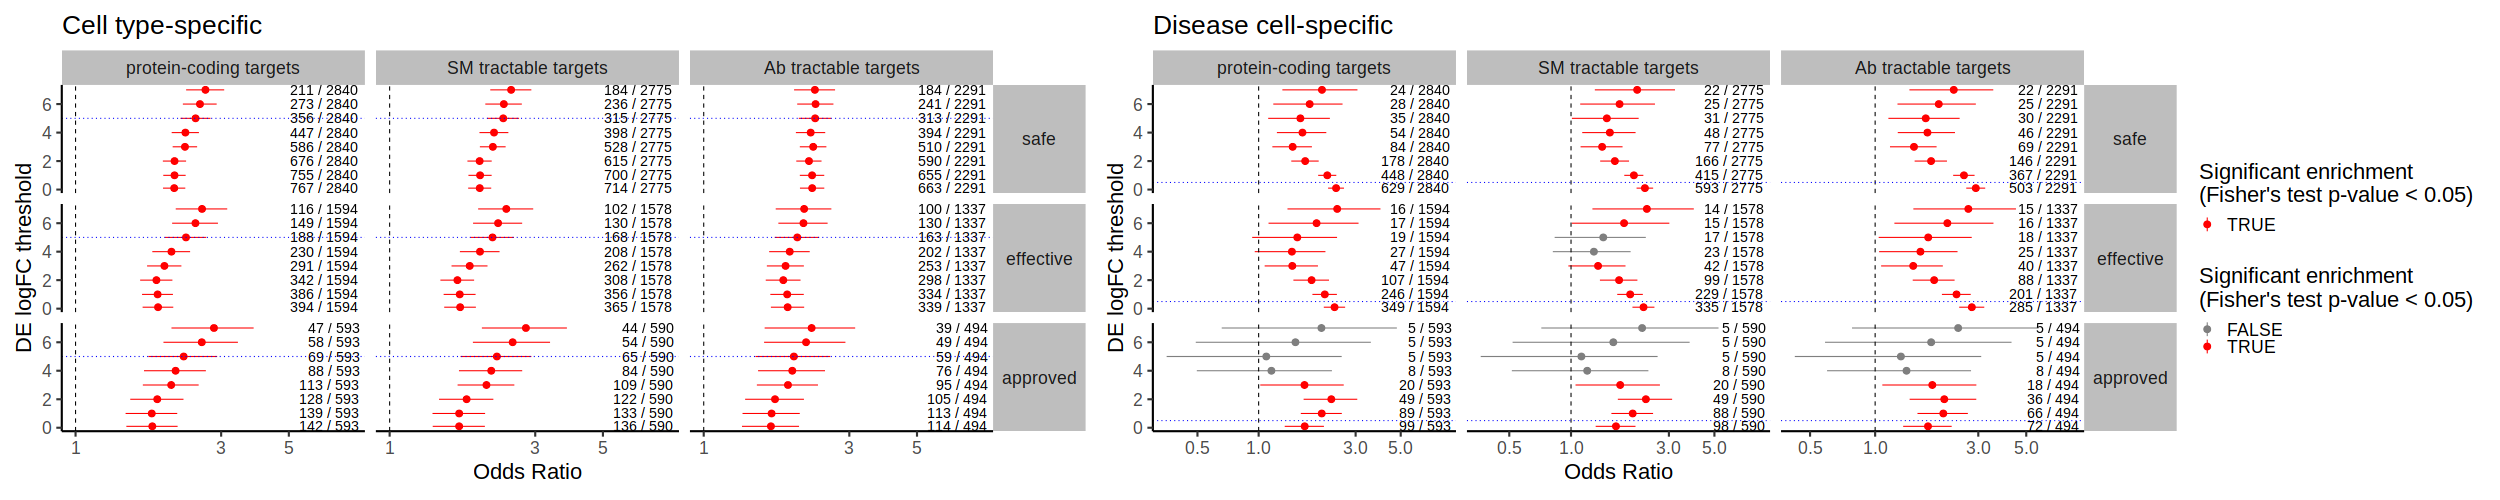

In [48]:
%%R -i lfc_OR_all -w 2500 -h 500 -i figdir

universe_labels <- c(
    'protein_coding_targets'= 'protein-coding targets',
    'sm_tractable_targets' = 'SM tractable targets',
    'ab_tractable_targets' = "Ab tractable targets"
    )

pl_df <- 
    filter(lfc_OR_all, 
               evidence %in% c('ct_marker_evidence', 'disease_evidence'),
           universe %in% c('protein_coding_targets', 'sm_tractable_targets', 'ab_tractable_targets')
          ) %>%
    mutate(universe = factor(universe, levels=c('protein_coding_targets', 'sm_tractable_targets',
       'ab_tractable_targets'))) 
#     %>%
#     mutate(evidence = recode(evidence, !!!as.list(evidence_labels))) 

    
pl1 <- plot_OR(filter(pl_df, evidence %in% c('ct_marker_evidence')), y_value='min_lfc',
        text_position='right', 
        evidence_levels=rev(c("Cell type marker", "disease marker")),
        clinical_status_levels = c('safe', 'effective', 'approved'),
               base_font_size=22
       ) +
    facet_grid(clinical_status~universe, scales='free_x',
               labeller = labeller(
                   universe=as_labeller(universe_labels)
               )
              ) +
    geom_hline(linetype=3, color='blue', yintercept=5) +
    ylab("DE logFC threshold") +
    expand_limits(x=8) +
    ggtitle("Cell type-specific")
    
pl2 <- plot_OR(filter(pl_df, 
               evidence %in% c('disease_evidence')), y_value='min_lfc',
        text_position='right', 
        evidence_levels=rev(c("Cell type marker", "disease marker")),
        clinical_status_levels = c('safe', 'effective', 'approved'),
               base_font_size=22
       ) +
    geom_hline(linetype=3, color='blue', yintercept=0.5) +
    facet_grid(clinical_status~universe, scales='free_x',
               labeller = labeller(
                   universe=as_labeller(universe_labels)
               )
              ) +
    expand_limits(x=8) +
    ylab("DE logFC threshold") +
    ggtitle("Disease cell-specific")

(pl1 + pl2) + plot_layout(guides='collect') +
    ggsave(paste0(figdir, 'OR_lfc_dependency.png'), height=10, width=30) +
    ggsave(paste0(figdir, 'OR_lfc_dependency.pdf'), height=10, width=30)


In [42]:
pl_df = targets_evidence_all_lfc.groupby(['disease_ontology_id', 'min_lfc']).sum().reset_index()

/tmp/ipykernel_231/112256373.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pl_df = targets_evidence_all_lfc.groupby(['disease_ontology_id', 'min_lfc']).sum().reset_index()


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


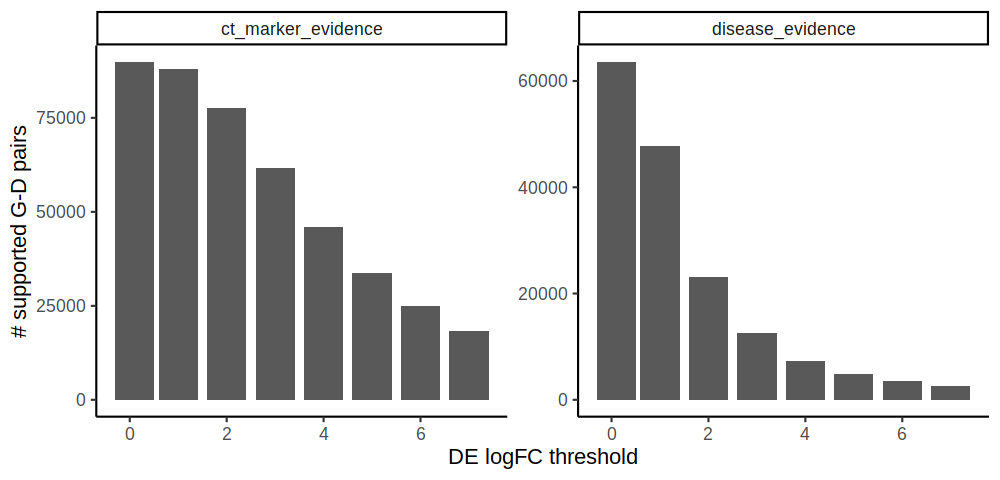

In [49]:
%%R -i pl_df -w 1000
pl_df %>%
pivot_longer(cols = c(ct_marker_evidence, disease_evidence), values_to='n_targets', names_to='sc_evidence') %>%
ggplot(aes(min_lfc, n_targets)) +
geom_col() +
facet_wrap(sc_evidence~., scales='free') +
theme_classic(base_size=22) +
xlab("DE logFC threshold") + ylab("# supported G-D pairs") +
ggsave_figdir('lfc_thresh_N', width=12, height=3)

## Variability between diseases

For both:
- Number of tested celltypes vs number of targets with evidence (for both)

In [434]:
# Get number of tested targets x disease
def _ncelltypes_DE(
    disease_ontology_id, 
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    ct_res = pd.read_csv(f'{data_dir}/DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    return(ct_res['high_level_cell_type_ontology_term_id'].nunique(), disease_res['high_level_cell_type_ontology_term_id'].nunique())

In [438]:
targets_evidence_all['n_cts_markers'] = np.nan
targets_evidence_all['n_cts_disease'] = np.nan

for disease_ontology_id in all_disease_ids:
    try:
        n_cts_markers, n_cts_disease = _ncelltypes_DE(disease_ontology_id)
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_cts_markers'] = n_cts_markers
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_cts_disease'] = n_cts_disease
        
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue

In [439]:
n_targets_by_disease = targets_evidence_all.groupby(['disease_ontology_id', 'disease']).sum()[['ct_marker_evidence', 'bulk_disease_evidence', 'disease_evidence', 'disease_ct_evidence']].reset_index()
n_targets_by_disease = pd.merge(n_targets_by_disease, targets_evidence_all[['n_cts_markers', 'n_cts_disease', 'disease_ontology_id']].drop_duplicates())

/tmp/ipykernel_231/1785789975.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_targets_by_disease = targets_evidence_all.groupby(['disease_ontology_id', 'disease']).sum()[['ct_marker_evidence', 'bulk_disease_evidence', 'disease_evidence', 'disease_ct_evidence']].reset_index()


In [440]:
n_targets_by_disease['disease_relevant_tissue'] = [disease_tissue_mapper[x.replace("_", ":")] for x in n_targets_by_disease.disease_ontology_id]

In [276]:
%%R -i n_targets_by_disease -w 1000 -h 500
pl1 <- n_targets_by_disease %>%
    ggplot(aes(n_cts_markers, ct_marker_evidence, fill=disease_relevant_tissue)) +
    geom_point(shape=21, size=4) +
#     ggrepel::geom_text_repel(aes(label=disease), max.overlaps = Inf) +
    theme_classic(base_size=21) +
    scale_fill_manual(values=tissue_palette, name='Disease-relevant tissue') +
    ggpubr::stat_cor(size=7) +
    ylab('# celltype marker genes') +
    xlab('# tested celltypes') 


pl3 <- n_targets_by_disease %>%
    ggplot(aes(n_cts_disease, disease_evidence, fill=disease_relevant_tissue)) +
    geom_point(shape=21, size=4) +
    ggrepel::geom_text_repel(data = . %>% mutate(disease = ifelse(disease_evidence > 2000, disease, NA)),
                             aes(label=disease)) +
    theme_classic(base_size=21) +
    scale_fill_manual(values=tissue_palette, name='Disease-relevant tissue') +
    ylab('# disease marker genes') +
    xlab('# tested celltypes') +
    ggpubr::stat_cor(size=7, aes(n_cts_disease, disease_ct_evidence), inherit.aes = FALSE)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


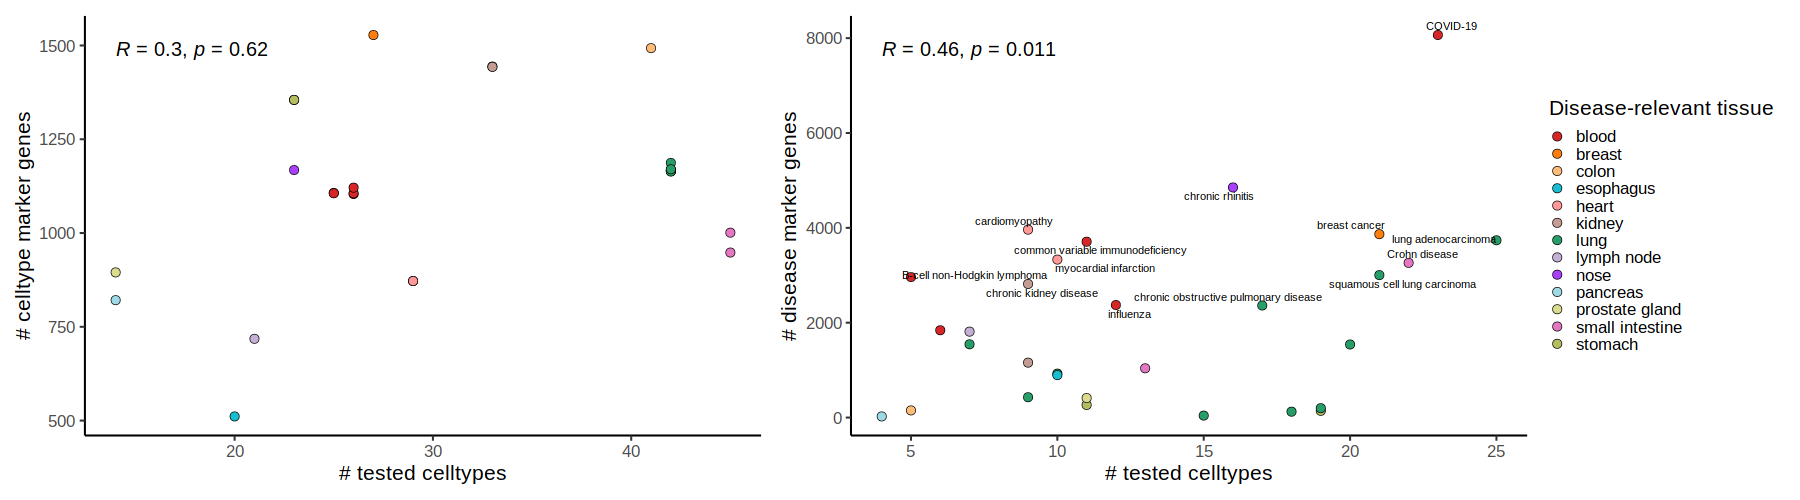

In [277]:
%%R -i n_targets_by_disease -w 1800 -h 500
pl_a <- (pl1 | pl3) + plot_layout(guides='collect') 
pl_a +
    ggsave(paste0(figdir, 'N_targets_vs_N_celltypes.png'), height=7, width=17) +
    ggsave(paste0(figdir, 'N_targets_vs_N_celltypes.pdf'), height=7, width=17) 

### Impact of size of single-cell cohort

In [594]:
# Get number of tested targets x disease
def _ndonors_DE(
    disease_ontology_id, 
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    pbulk_adata = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad', backed=True)
    count_donors = pbulk_adata.obs[['disease', 'donor_id']].drop_duplicates().value_counts('disease')
    n_normal, n_disease = count_donors['normal'], count_donors[count_donors.index != 'normal'][0]
    n_normal_cells = pbulk_adata[pbulk_adata.obs['disease'] == 'normal'].obs['n_cells'].sum()
    n_disease_cells = pbulk_adata[pbulk_adata.obs['disease'] != 'normal'].obs['n_cells'].sum()
    mean_cells_disease_donor = pbulk_adata[pbulk_adata.obs['disease'] != 'normal'].obs[['n_cells','donor_id']].groupby('donor_id').sum().mean()[0]
    return(n_normal, n_disease, n_normal_cells, n_disease_cells, mean_cells_disease_donor)

In [595]:
targets_evidence_all['n_normal_donors'] = np.nan
targets_evidence_all['n_disease_donors'] = np.nan

for disease_ontology_id in targets_evidence_all.disease_ontology_id.unique():
    try:
        n_normal, n_disease, n_normal_cells, n_disease_cells,mean_cells_disease_donor = _ndonors_DE(disease_ontology_id)
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_normal_donors'] = n_normal
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_disease_donors'] = n_disease
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_disease_cells'] = n_disease_cells
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_normal_cells'] = n_normal_cells
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'mean_cells_disease_donor'] = mean_cells_disease_donor
        
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
    except RuntimeError:
        print(f'missing {disease_ontology_id}')
        continue

In [596]:
n_donors_by_disease = targets_evidence_all.groupby('disease_ontology_id').sum()[['ct_marker_evidence', 'disease_evidence']].reset_index()
n_donors_by_disease = pd.merge(n_donors_by_disease, targets_evidence_all[['n_normal_donors', 'n_disease_donors','n_disease_cells', 'n_normal_cells', 'disease_ontology_id', 'mean_cells_disease_donor']].drop_duplicates())

/tmp/ipykernel_231/2143333745.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_donors_by_disease = targets_evidence_all.groupby('disease_ontology_id').sum()[['ct_marker_evidence', 'disease_evidence']].reset_index()


In [597]:
data = pd.merge(OR_disease_df, n_donors_by_disease)
# sns.scatterplot(x=np.log10(data['n_normal_donors']), y=np.log(data['odds_ratio']));
# plt.show()

In [282]:
%%R -i n_donors_by_disease -w 1000 -h 500
pl1 <- n_donors_by_disease %>%
ggplot(aes(log10(n_disease_donors), disease_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('# disease marker\ngenes') +
xlab('') +
ggpubr::stat_cor(size=6)
pl2 <- n_donors_by_disease %>%
ggplot(aes(log10(n_normal_donors), disease_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('') +
xlab('') +
ggpubr::stat_cor(size=6)
pl3 <- n_donors_by_disease %>%
ggplot(aes(log10(n_disease_donors), ct_marker_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('# celltype marker\ngenes') +
xlab('# disease donors (log10)') +
ggpubr::stat_cor(size=6)
pl4 <- n_donors_by_disease %>%
ggplot(aes(log10(n_normal_donors), ct_marker_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('') +
xlab('# normal donors (log10)') +
ggpubr::stat_cor(size=6)

pl_b <- (pl1 | pl2) / (pl3 | pl4) 
ggsave_figdir('no_markers_vs_donors', width=15, height=10)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


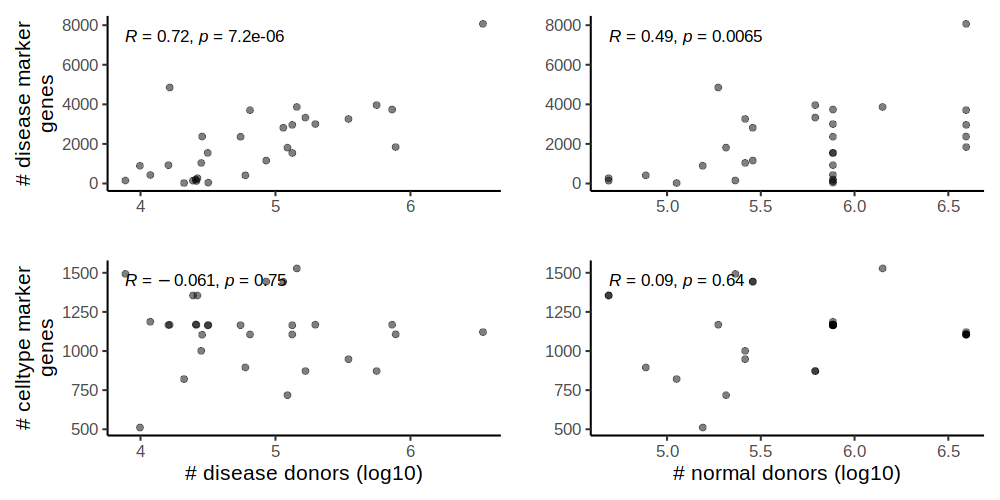

In [301]:
%%R -i n_donors_by_disease -w 1000 -h 500
pl1 <- n_donors_by_disease %>%
ggplot(aes(log10(n_disease_cells), disease_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('# disease marker\ngenes') +
xlab('') +
ggpubr::stat_cor(size=6)
pl2 <- n_donors_by_disease %>%
ggplot(aes(log10(n_normal_cells), disease_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('') +
xlab('') +
ggpubr::stat_cor(size=6)
pl3 <- n_donors_by_disease %>%
ggplot(aes(log10(n_disease_cells), ct_marker_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('# celltype marker\ngenes') +
xlab('# disease donors (log10)') +
ggpubr::stat_cor(size=6)
pl4 <- n_donors_by_disease %>%
ggplot(aes(log10(n_normal_cells), ct_marker_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('') +
xlab('# normal donors (log10)') +
ggpubr::stat_cor(size=6)

(pl1 | pl2) / (pl3 | pl4) 

In [283]:
%%R -i data -w 1000 -h 300
my_comparisons <- list( c('3-10', "10-100"))

pl_c <- data %>%
    filter(evidence == 'disease_evidence') %>%
    arrange(n_disease_donors) %>%
    # filter(disease != 'pulmonary emphysema') %>%
    mutate(disease = factor(disease, levels=unique(disease))) %>%
    mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=(c('druggable', 'safe', 'effective', 'approved')))) %>%
    mutate(n_disease_donors_bin = cut(log10(n_disease_donors), breaks=c(0,1,2,3), labels=c('3-10', '10-100', '> 100'))) %>%
    # mutate(n_disease_donors_bin = ifelse(n_disease_donors <= 10, '< 10', '> 10')) %>%
    ggplot(aes(
        as.factor(n_disease_donors_bin),
        n_supported_approved/n_supported
    #     log(odds_ratio)
              )) +
    geom_boxplot(varwidth=TRUE, outlier.alpha=0) +
    geom_jitter(width=0.1) +
    xlab('No. of disease donors in scRNA-seq dataset') +
    ylab('Fraction of supported targets\n(disease markers)') +
    ggpubr::stat_compare_means(comparisons = my_comparisons, size=5, method='wilcox.test', format='p.format', ) +
    facet_wrap(clinical_status~., scales='free') +
    theme_classic(base_size=20) + 
    scale_y_continuous(expand=expansion(mult = c(0.1, .1))) +
    theme(strip.text = element_text(hjust = 0), strip.background=element_rect(color=NA, fill='grey'),
                                        panel.spacing=unit(1,"lines")
                                       )

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


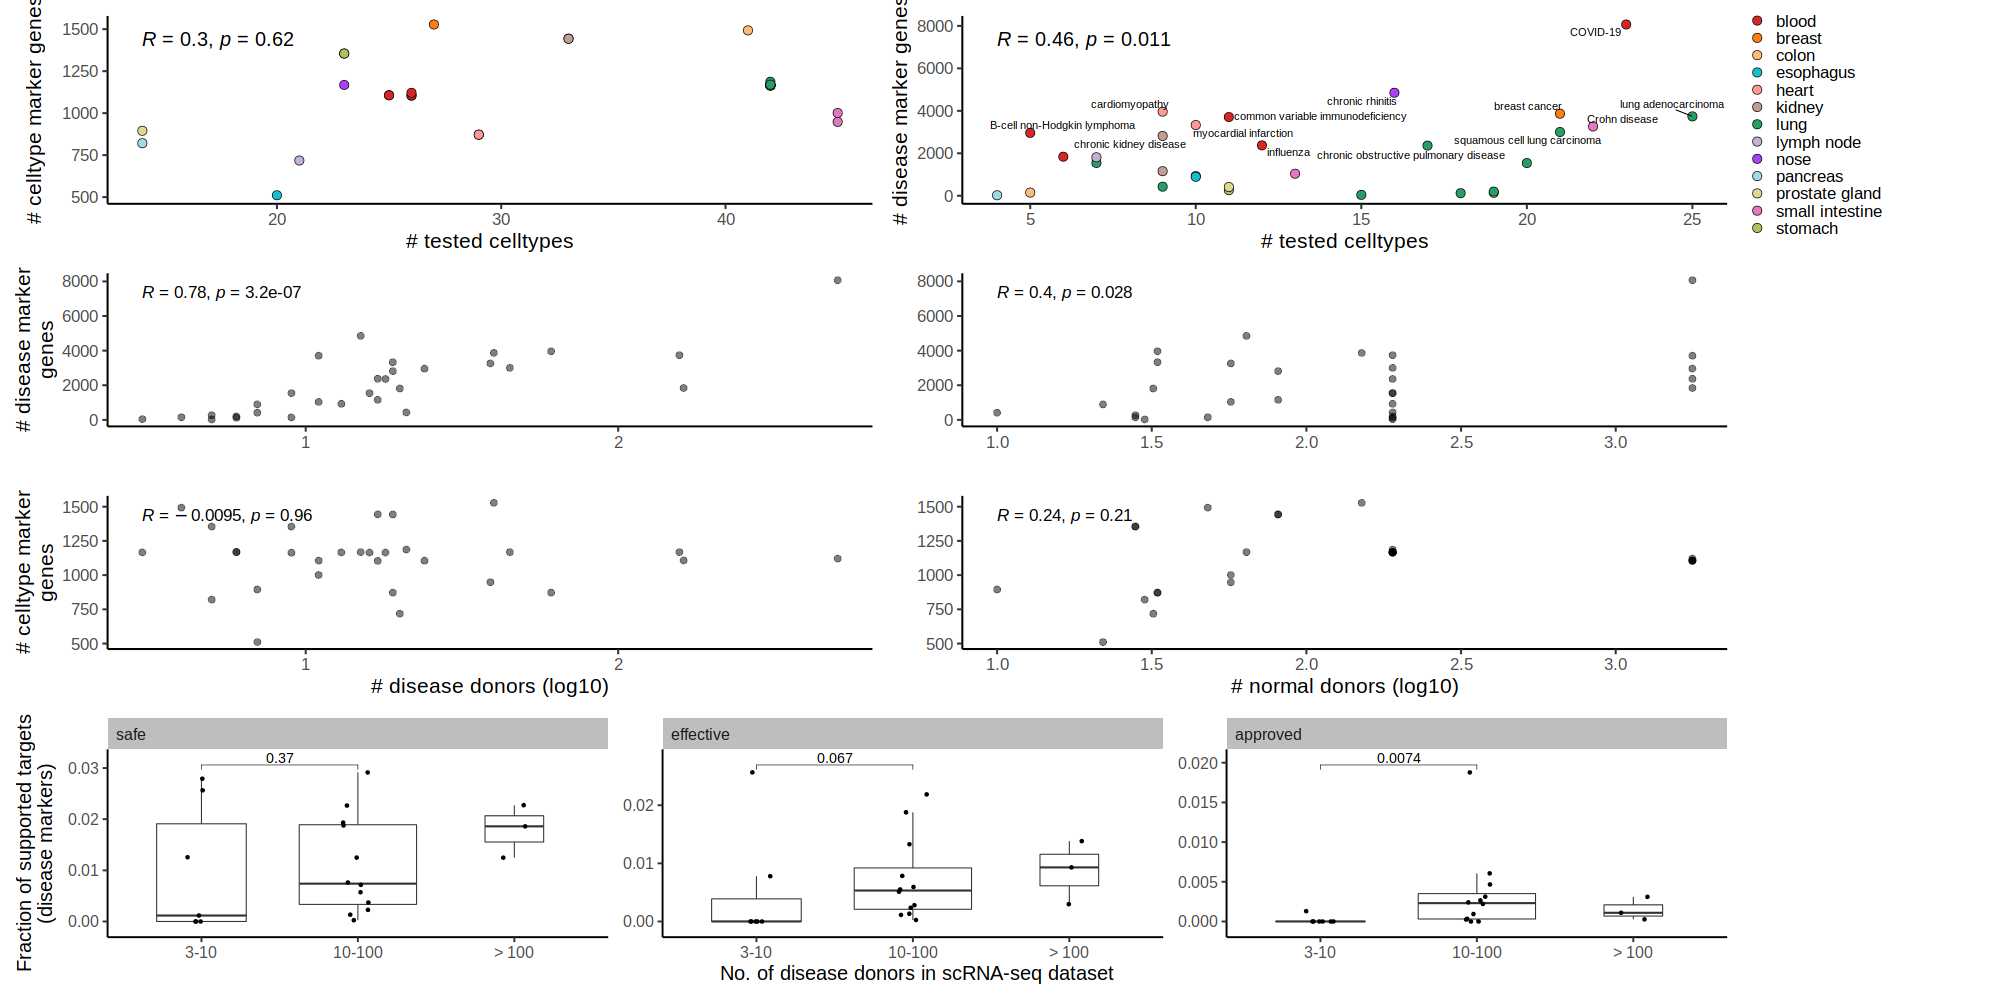

In [292]:
%%R -w 2000 -h 1000
(pl_a / pl_b / pl_c) + plot_layout(heights = c(1,2,1)) +
 ggsave_figdir('disease_variability', width=15, height=17)

In [626]:
df = pd.merge(n_targets_by_disease, data)
df = df[(df['clinical_status'] == 'is_effective') & (df['evidence'] == 'disease_evidence')].copy()

In [627]:
df['y'] = df.n_supported_approved/df.n_supported

PearsonRResult(statistic=0.2768028826861814, pvalue=0.21236905033990544)

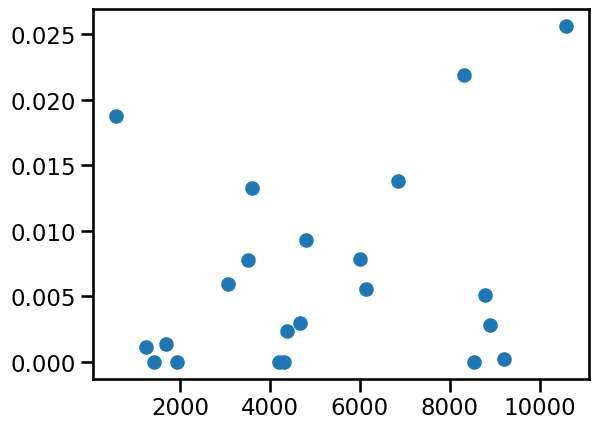

In [629]:
plt.scatter(df.mean_cells_disease_donor, df.y);
scipy.stats.pearsonr(df.mean_cells_disease_donor, df.y)

In [633]:
scipy.stats.pearsonr(df.n_disease_donors, df.y)

PearsonRResult(statistic=0.18267357902695583, pvalue=0.4158273707747153)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


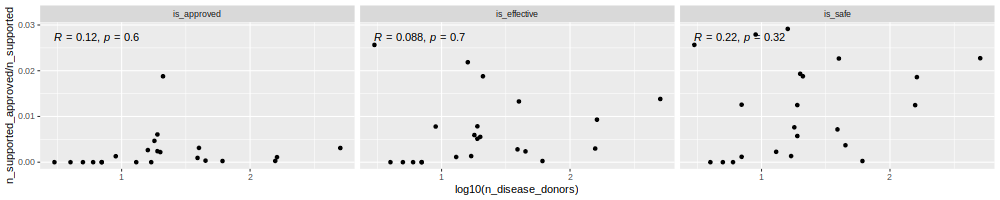

In [687]:
%%R -i data -w 1000 -h 200

data %>%
    filter(evidence=='disease_evidence') %>%
    ggplot(aes(log10(n_disease_donors), n_supported_approved/n_supported)) +
#     ggplot(aes(log10(n_disease_cells + n_normal_cells), n_supported_approved/n_supported)) +
#     ggplot(aes(mean_cells_disease_donor, n_supported)) +
    geom_point()+
    ggpubr::stat_cor() +
            facet_wrap(clinical_status~.)
            
# data %>%
#     filter(n_disease_cells < 1000000) %>%
#     ggplot(aes(n_disease_donors, n_supported_approved/n_supported)) +
#     geom_point()+
#     ggpubr::stat_cor()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


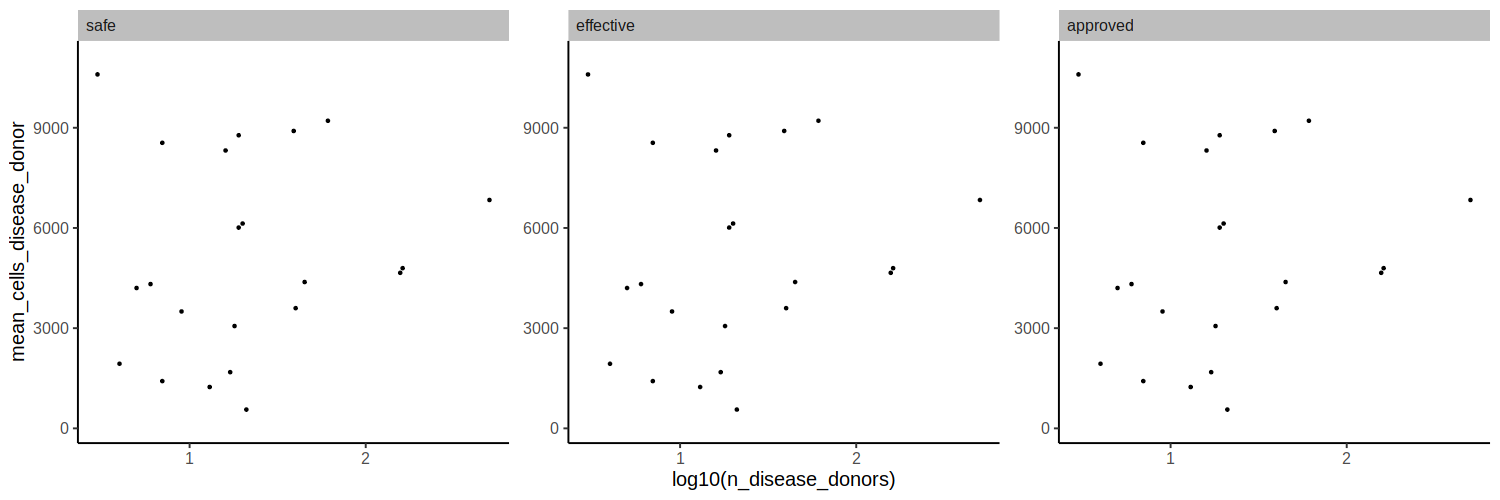

In [661]:
%%R -i data -w 1500 -h 500
my_comparisons <- list( c('3-10', "10-100"))

data %>%
    filter(evidence == 'disease_evidence') %>%
    arrange(n_disease_donors) %>%
    # filter(disease != 'pulmonary emphysema') %>%
    mutate(disease = factor(disease, levels=unique(disease))) %>%
    mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=(c('druggable', 'safe', 'effective', 'approved')))) %>%
#     mutate(n_disease_donors_bin = cut(log10(mean_cells_disease_donor), breaks=c(0,1,2,3), labels=c('3-10', '10-100', '> 100'))) %>%
    # mutate(n_disease_donors_bin = ifelse(n_disease_donors <= 10, '< 10', '> 10')) %>%
    ggplot(aes(
#         mean_cells_disease_donor,
        log10(n_disease_donors),
        mean_cells_disease_donor
    #     log(odds_ratio)
              )) +
#     geom_boxplot(varwidth=TRUE, outlier.alpha=0) +
    geom_point() +
#     xlab('No. of disease donors in scRNA-seq dataset') +
#     ylab('Fraction of supported targets\n(disease markers)') +
#     ggpubr::stat_compare_means(comparisons = my_comparisons, size=5, method='wilcox.test', format='p.format', ) +
    facet_wrap(clinical_status~., scales='free') +
    theme_classic(base_size=20) + 
    scale_y_continuous(expand=expansion(mult = c(0.1, .1))) +
    theme(strip.text = element_text(hjust = 0), strip.background=element_rect(color=NA, fill='grey'),
                                        panel.spacing=unit(1,"lines")
                                       )

(array([216.,  12.,  24.,   0.,   0.,   0.,   0.,   0.,   0.,  12.]),
 array([   7737. ,  351588.1,  695439.2, 1039290.3, 1383141.4, 1726992.5,
        2070843.6, 2414694.7, 2758545.8, 3102396.9, 3446248. ]),
 <BarContainer object of 10 artists>)

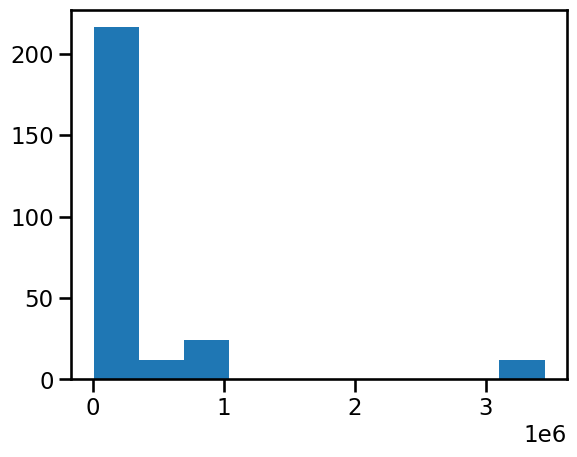

In [619]:
plt.hist(df.n_disease_cells);
# scipy.stats.pearsonr(df.n_cts_disease + df.n_disease_donors, df.mean_cells_disease_donor)

In [607]:
%%R -i df

df$tot_cells = df$n_disease_cells + df$n_normal_cells
mod1 <- lm(formula = y ~ mean_cells_disease_donor, data = df)
mod2 <- lm(formula = y ~ mean_cells_disease_donor + tot_cells, data = df)
# mod2 <- lm(y ~ n_cts_disease, data = df)
# mod3 <- lm(y ~ n_disease_donors + n_cts_disease, data = df)

anova(mod1, mod2)
# summary(mod1)

Analysis of Variance Table

Model 1: y ~ mean_cells_disease_donor
Model 2: y ~ mean_cells_disease_donor + tot_cells
  Res.Df      RSS Df Sum of Sq      F    Pr(>F)    
1    262 0.057097                                  
2    261 0.053396  1 0.0037014 18.093 2.934e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [608]:
%%R
print(summary(mod1))
print(summary(mod2))


Call:
lm(formula = y ~ mean_cells_disease_donor, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.014442 -0.008309 -0.005119  0.002133  0.098808 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)   
(Intercept)              4.488e-03  1.847e-03   2.430  0.01579 * 
mean_cells_disease_donor 9.393e-07  3.140e-07   2.992  0.00304 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01476 on 262 degrees of freedom
Multiple R-squared:  0.03303,	Adjusted R-squared:  0.02934 
F-statistic:  8.95 on 1 and 262 DF,  p-value: 0.003039


Call:
lm(formula = y ~ mean_cells_disease_donor + tot_cells, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.020915 -0.007766 -0.003901  0.002135  0.099804 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              1.573e-03  1.916e-03   0.821  0.41260    
mean_cells_disease_donor 9.347e-0

In [609]:
scipy.stats.pearsonr(df.n_cts_disease, df.n_disease_donors)

PearsonRResult(statistic=0.3979823476121257, pvalue=1.878011303503463e-11)

In [565]:
scipy.stats.pearsonr(np.log10(df.n_disease_cells), np.log10(df.n_disease_donors))

PearsonRResult(statistic=0.8832836029200217, pvalue=3.581359590239092e-88)

In [577]:
(np.log10(df.n_disease_cells + df.n_normal_cells), np.log10(df.n_cts_markers), '.')

PearsonRResult(statistic=0.30889547812636275, pvalue=3.040463791826593e-07)

## Tractability on novel targets

In [81]:
# targets_evidence_all['ab_tractable'] = targets_evidence_all.gene_id.isin(universe_dict['ab_tractable_targets']).astype(int)
# targets_evidence_all['sm_tractable'] = targets_evidence_all.gene_id.isin(universe_dict['sm_tractable_targets']).astype(int)
# targets_evidence_all['tractable'] = targets_evidence_all.gene_id.isin(universe_dict['sm_tractable_targets'] + universe_dict['ab_tractable_targets']).astype(int)

In [82]:
# universe_dict.keys()

In [135]:
import itertools
tractability_targets = []
for tract in ['ab_tractable_targets', 'sm_tractable_targets']:
    combinations = list(itertools.product(all_disease_ids, universe_dict[tract]))
    # Create a DataFrame with the combinations
    tr_df = pd.DataFrame(combinations, columns=['disease_ontology_id', 'gene_id'])
    tr_df[tract] = 1
    tractability_targets.append(tr_df) 

In [136]:
tractability_targets_df = pd.merge(tractability_targets[0], tractability_targets[1], how='outer').fillna(0)
tractability_targets_df

,disease_ontology_id,gene_id,ab_tractable_targets,sm_tractable_targets
0,MONDO_0005097,ENSG00000000003,1.0,0.0
1,MONDO_0005097,ENSG00000000005,1.0,0.0
2,MONDO_0005097,ENSG00000000938,1.0,1.0
3,MONDO_0005097,ENSG00000000971,1.0,1.0
4,MONDO_0005097,ENSG00000001036,1.0,1.0
...,...,...,...,...
455485,MONDO_0015517,LRG_882,0.0,1.0
455486,MONDO_0015517,LRG_90,0.0,1.0
455487,MONDO_0015517,LRG_990,0.0,1.0
455488,MONDO_0015517,LRG_991,0.0,1.0


In [137]:
test_df = targets_evidence_all[targets_evidence_all.is_safe == 0].copy()
test_df = pd.merge(test_df, tractability_targets_df, how='outer').fillna(0)

In [138]:
test_df['tractable'] = ((test_df['ab_tractable_targets'] == 1) | (test_df['sm_tractable_targets'] == 1)).astype(int)

In [139]:
evidence_cols = ['ct_marker_evidence', 'disease_evidence','all_sc_evidence', 'has_genetic_support']

In [140]:
test_df = test_df[test_df.gene_id.isin(universe_dict['protein_coding_targets'])].copy()

In [ ]:
OR_tractability_all = pd.DataFrame()
for ev in evidence_cols:
    for cl in ['tractable', 'sm_tractable_targets', 'ab_tractable_targets']:
        or_df = association_utils.get_OR(
            test_df,
            evidence_col = ev,
            clinical_status_col = cl,
            gene_universe = universe_dict['protein_coding_targets']
            )
        or_df['evidence'] = ev
        OR_tractability_all = pd.concat([OR_tractability_all, or_df])

In [196]:
OR_tractability_all.drop('baseline', axis=1, inplace=True)

In [197]:
# Add fraction in all protein-coding genes as baseline
baseline = {'sm_tractable_targets':pd.Series(universe_dict['protein_coding_targets']).isin(universe_dict['sm_tractable_targets']).sum()/len(universe_dict['protein_coding_targets']),
'ab_tractable_targets':pd.Series(universe_dict['protein_coding_targets']).isin(universe_dict['ab_tractable_targets']).sum()/len(universe_dict['protein_coding_targets']),
'tractable':pd.Series(universe_dict['protein_coding_targets']).isin(universe_dict['sm_tractable_targets'] + universe_dict['ab_tractable_targets']).sum()/len(universe_dict['protein_coding_targets'])}

baseline_df = pd.DataFrame([baseline.keys(), baseline.values()], index=['clinical_status', 'baseline']).T
baseline_df['baseline'] = baseline_df['baseline'].astype('float64')
OR_tractability_all = pd.merge(OR_tractability_all, baseline_df, how='left')

In [198]:
OR_tractability_all['baseline'] = OR_tractability_all['baseline'].astype('float64')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


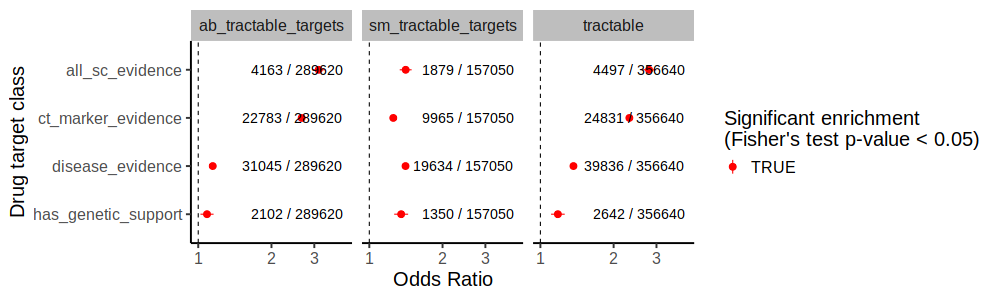

In [199]:
%%R -i OR_tractability_all -h 300 -w 1000
plot_OR(OR_tractability_all, y_value='evidence', 
        evidence_levels=c('has_genetic_support', 'disease_evidence', 'ct_marker_evidence', 'all_sc_evidence'),
        clinical_status_levels = c('ab_tractable_targets', 'sm_tractable_targets', 'tractable')
       ) +
facet_grid(.~clinical_status)  +
expand_limits(x=4)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


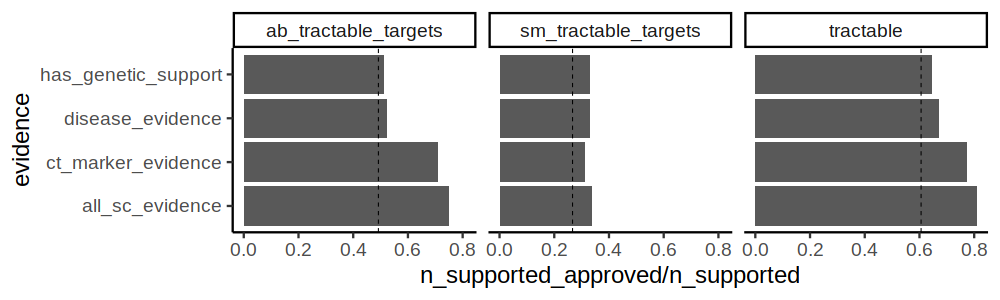

In [205]:
%%R -i OR_tractability_all -h 300 -w 1000
OR_tractability_all %>%
ggplot(aes(evidence, n_supported_approved/n_supported)) +
geom_col() +
facet_grid(.~clinical_status) +
coord_flip() +
geom_hline(aes(yintercept=baseline), linetype=2, color='black') +
theme_classic(base_size=24)

In [292]:
# at least one gene with genetic support
keep_diseases = targets_evidence_all[targets_evidence_all.is_safe == 0].groupby('disease_ontology_id').sum()[targets_evidence_all[targets_evidence_all.is_safe == 0].groupby('disease_ontology_id').sum()['has_genetic_support'] > 0].index

/tmp/ipykernel_223/2097848929.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  keep_diseases = targets_evidence_all[targets_evidence_all.is_safe == 0].groupby('disease_ontology_id').sum()[targets_evidence_all[targets_evidence_all.is_safe == 0].groupby('disease_ontology_id').sum()['has_genetic_support'] > 0].index
/tmp/ipykernel_223/2097848929.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  keep_diseases = targets_evidence_all[targets_evidence_all.is_safe == 0].groupby('disease_ontology_id').sum()[targets_evidence_all[targets_evidence_all.is_safe == 0].groupby('disease_ontology_id').sum()['has_genetic_s

In [294]:
OR_tractability = association_utils.compute_grouped_OR(
    targets_evidence_all[(targets_evidence_all['disease_ontology_id'].isin(keep_diseases)) & (targets_evidence_all.is_safe == 0)], 
    group_by = 'disease_ontology_id', 
    evidence_cols = evidence_cols,
    clinical_status_cols = ['sm_tractable', 'ab_tractable', 'tractable'],
    gene_universe = universe_dict['protein_coding_targets']
    )

In [295]:
OR_tractability['disease_relevant_tissue'] = [disease_tissue_mapper[x.replace('_', ':')] for x in OR_tractability.disease_ontology_id]
OR_tractability['disease'] = [disease_name_mapper[x.replace('_', ':')] for x in OR_tractability.disease_ontology_id]

In [296]:
order_disease = targets_evidence_all[['disease', 'disease_relevant_tissue']].drop_duplicates().sort_values('disease_relevant_tissue')['disease']

In [297]:
# Add fraction in all protein-coding genes as baseline
baseline = {'sm_tractable':pd.Series(universe_dict['protein_coding_targets']).isin(universe_dict['sm_tractable_targets']).sum()/len(universe_dict['protein_coding_targets']),
'ab_tractable':pd.Series(universe_dict['protein_coding_targets']).isin(universe_dict['ab_tractable_targets']).sum()/len(universe_dict['protein_coding_targets']),
'tractable':pd.Series(universe_dict['protein_coding_targets']).isin(universe_dict['sm_tractable_targets'] + universe_dict['ab_tractable_targets']).sum()/len(universe_dict['protein_coding_targets'])}

baseline_df = pd.DataFrame([baseline.keys(), baseline.values()], index=['clinical_status', 'baseline']).T
baseline_df['baseline'] = baseline_df['baseline'].astype('float64')
OR_tractability = pd.merge(OR_tractability, baseline_df, how='left')

In [298]:
OR_tractability['baseline'] = OR_tractability['baseline'].astype('float64')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


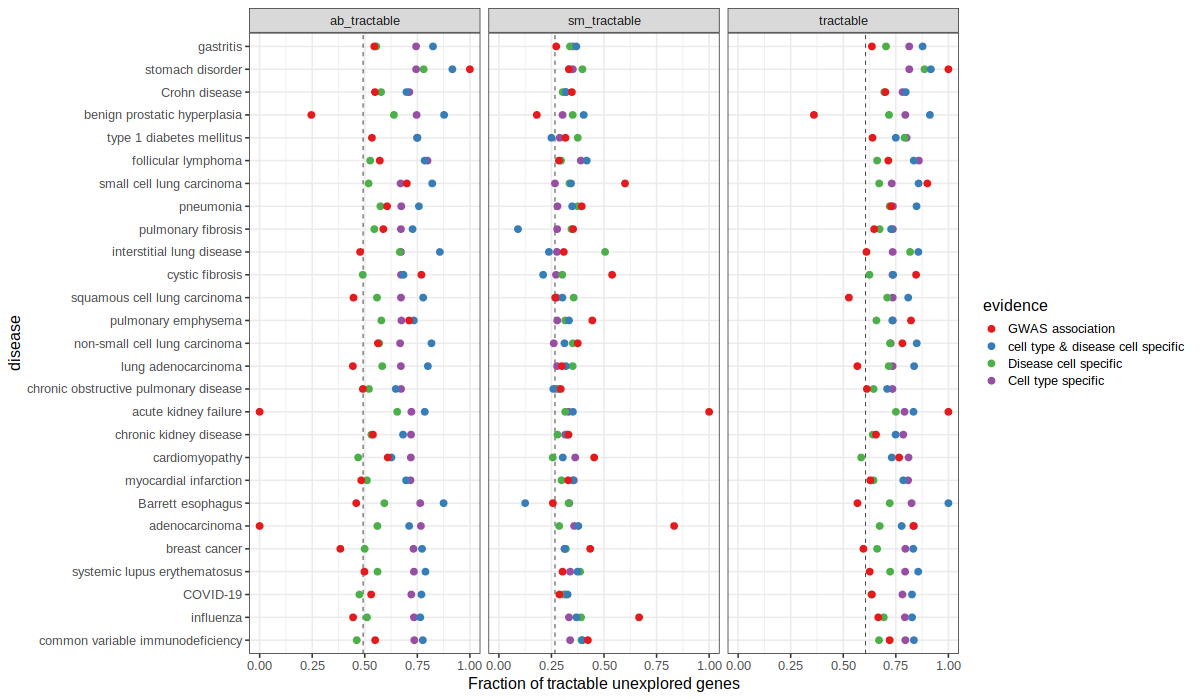

In [307]:
%%R -i OR_tractability -w 1200 -h 700 -i order_disease 
# order_disease <- OR_tractability %>%
#     filter(evidence == 'has_genetic_support' & clinical_status=='tractable') %>%
#     mutate(frac = n_supported_approved/n_supported) %>%
#     arrange(frac) %>%
#     pull(disease)

pl1 <- OR_tractability %>%
    mutate(evidence = factor(evidence, levels=rev(evidence_cols))) %>%
    mutate(disease = factor(disease, levels=order_disease)) %>%
    ggplot(aes(disease, n_supported_approved/n_supported, color=evidence)) +
    geom_hline(aes(yintercept=baseline), linetype=2, color='grey30') +
    geom_point(size=3) +
    facet_grid(.~clinical_status) +
    coord_flip() +
    ylab("Fraction of tractable unexplored genes") +
    scale_color_brewer(palette='Set1', labels=evidence_labels) +
    theme_bw(base_size=16)
    
pl1 + 
ggsave_figdir('tractability_suppl', width=14, height=8)

In [302]:
OR_tractability['frac'] = OR_tractability.n_supported_approved/OR_tractability.n_supported

In [327]:
scipy.stats.ttest_ind(
    OR_tractability[(OR_tractability.evidence == 'has_genetic_support') & (OR_tractability.clinical_status == 'sm_tractable')]['frac'],
    OR_tractability[(OR_tractability.evidence == 'all_sc_evidence') & (OR_tractability.clinical_status == 'sm_tractable')]['frac']
)

Ttest_indResult(statistic=2.3808690315421295, pvalue=0.02096980166016152)

In [328]:
OR_tractability[(OR_tractability.evidence == 'has_genetic_support') & (OR_tractability.clinical_status == 'sm_tractable')]['frac'].mean()

0.40480026941873637

In [329]:
OR_tractability[(OR_tractability.evidence == 'ct_marker_evidence') & (OR_tractability.clinical_status == 'ab_tractable')]['frac'].mean()
OR_tractability[(OR_tractability.evidence == 'all_sc_evidence') & (OR_tractability.clinical_status == 'sm_tractable')]['frac'].mean()

0.31348760899023925

In [304]:
%%R -i OR_tractability -w 1000 -h 400 -i evidence_cols
pl1 <- OR_tractability %>%
    mutate(evidence = factor(evidence, levels=rev(evidence_cols))) %>%
    mutate(clinical_status = factor(clinical_status, levels=c('tractable', 'ab_tractable', 'sm_tractable'))) %>%
    ggplot(aes(evidence, n_supported_approved/n_supported, color=evidence)) +
    geom_boxplot(outlier.alpha=0) +
    geom_jitter(size=1, width=0.2, ) +
    geom_hline(aes(yintercept=baseline), linetype=2, color='grey30') +
    facet_grid(clinical_status~.) +
    scale_x_discrete(labels=evidence_labels) +
    coord_flip() +
    ylab("Fraction of tractable unexplored genes") +
        scale_color_brewer(palette='Set1', labels=evidence_labels) +
        theme_bw(base_size=16)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


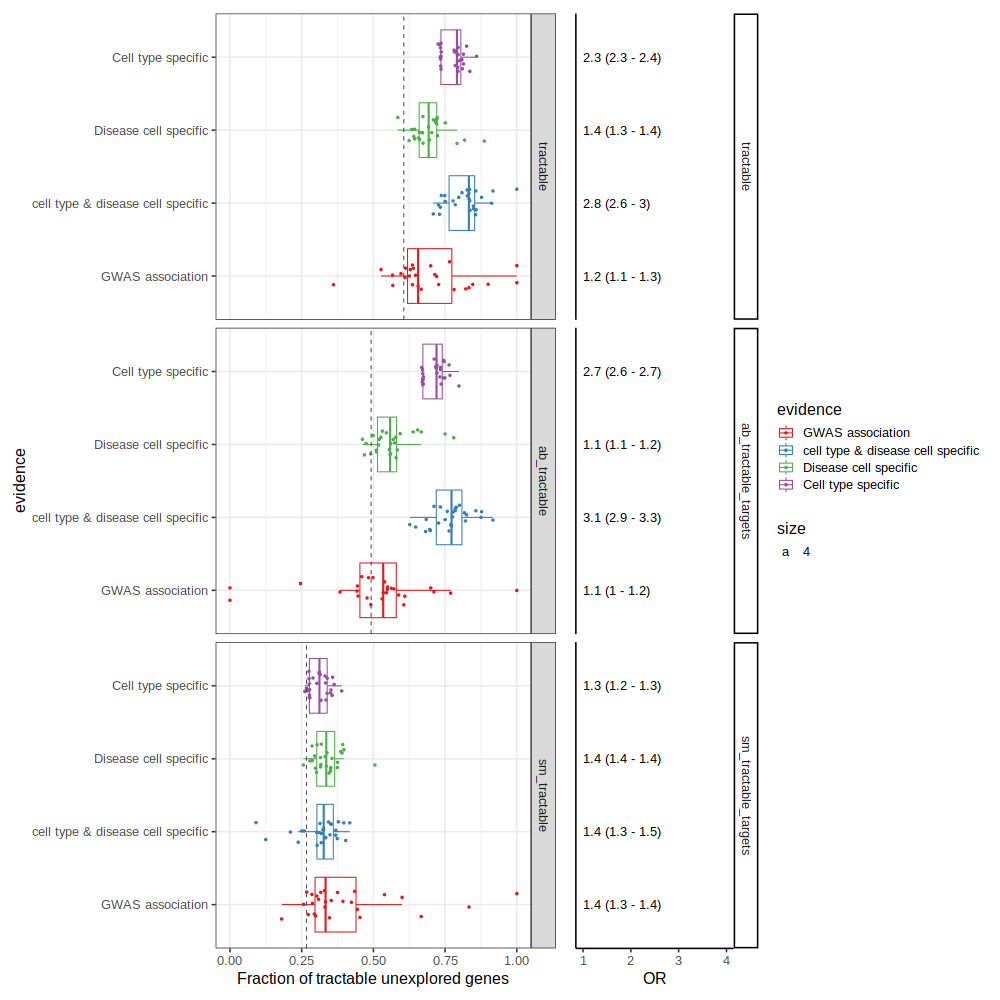

In [305]:
%%R -w 1000 -h 1000
# pl2 <- OR_tractability_all %>%
# mutate(evidence = factor(evidence, levels=rev(evidence_cols))) %>%
#     mutate(clinical_status = factor(clinical_status, levels=c('tractable', 'ab_tractable_targets', 'sm_tractable_targets'))) %>%
#     ggplot(aes(odds_ratio, evidence)) +
# #     geom_text(aes(label = round(pval, 3), x=4)) +
#     facet_grid(clinical_status~.) +
#     geom_point() +
#     geom_vline(aes(xintercept=1), linetype=2, color='grey30') +
#     geom_pointrange(aes(xmin=ci_low, xmax=ci_high)) +
#     scale_y_discrete(labels=evidence_labels) +
#     ylab("Fraction of tractable unexplored genes") +
# #     scale_color_brewer(palette='Set1', labels=evidence_labels) +
#     theme_bw(base_size=16) +
# #     scale_x_log10() +
#         xlab('Odds Ratio') +
#     expand_limits(x=0)
    
pl2 <- OR_tractability_all %>%
mutate(evidence = factor(evidence, levels=rev(evidence_cols))) %>%
    mutate(clinical_status = factor(clinical_status, levels=c('tractable', 'ab_tractable_targets', 'sm_tractable_targets'))) %>%
    ggplot(aes(odds_ratio, evidence)) +
    geom_text(aes(label = paste0(round(odds_ratio, 1), " (", round(ci_low, 1), ' - ', round(ci_high, 1), ')'), x=1,
                  hjust=0, size=4,
                 )) +
#     geom_text(aes(label = sprintf("p = %.2e", pval), x=2, hjust=0)) +
    facet_grid(clinical_status~.) +
    scale_y_discrete(labels=evidence_labels) +
    xlab("OR") +
    expand_limits(x=4) +
    theme_classic(base_size=16) 

pl1 + (pl2 + remove_y_axis()) +
 plot_layout(guides='collect', widths=c(2,1)) +
ggsave_figdir('tractability_main', width=12, height=9)

Are tractable genes more constrained? (table downloaded from https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/constraint/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz)

In [158]:
gene_table = pd.read_table("../data/gnomad.v2.1.1.lof_metrics.by_gene.txt")
loeuf_table = gene_table[['gene_id', 'oe_lof', 'gene']]
loeuf_table = loeuf_table.rename({'gene':'gene_name', 'oe_lof':'LOEUF'}, axis=1)

tractability_df = test_df[['gene_id', 'ab_tractable_targets', 'sm_tractable_targets']].drop_duplicates()
tractability_df = pd.merge(tractability_df, genes[['gene_id', 'gene_name']], how='left')

df = pd.merge(tractability_targets_df.drop('disease_ontology_id', axis=1).drop_duplicates(), loeuf_table, how='outer').dropna()
df['ab_tractable_targets'] = np.where(df['ab_tractable_targets'] == 1, True, False)
df['sm_tractable_targets'] = np.where(df['sm_tractable_targets'] == 1, True, False)
df

,gene_id,ab_tractable_targets,sm_tractable_targets,LOEUF,gene_name
0,ENSG00000000003,True,False,0.38144,TSPAN6
1,ENSG00000000005,True,False,0.46109,TNMD
2,ENSG00000000938,True,True,0.21554,FGR
3,ENSG00000000971,True,True,0.20396,CFH
4,ENSG00000001036,True,True,0.57705,FUCA2
...,...,...,...,...,...
14847,ENSG00000267673,False,True,0.67891,FDX1L
14849,ENSG00000269858,False,True,0.17314,EGLN2
14850,ENSG00000271303,False,True,0.49856,SRXN1
14851,ENSG00000272047,False,True,0.64645,GTF2H5


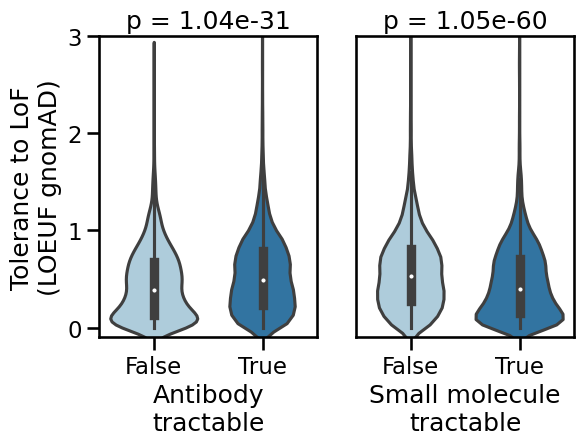

In [182]:
plt.subplot(1,2,1)
sns.violinplot(data=df, x='ab_tractable_targets', y='LOEUF', palette='Paired');
plt.ylabel('Tolerance to LoF\n(LOEUF gnomAD)');
plt.ylim(-0.1,3);
plt.xlabel("Antibody\ntractable");

test_result = scipy.stats.ranksums(
    df[df['ab_tractable_targets'] == False]['LOEUF'], 
    df[df['ab_tractable_targets'] == True]['LOEUF'])
p_value = "{:.2e}".format(test_result.pvalue)
plt.title( f'p = {p_value}')

plt.subplot(1,2,2)
sns.violinplot(data=df, x='sm_tractable_targets', y='LOEUF', palette='Paired');
plt.ylabel('')  # This will remove the y-axis label
plt.ylim(-0.1, 3)
plt.yticks([])  # This will remove the y-axis ticks
plt.xlabel("Small molecule\ntractable")
test_result = scipy.stats.ranksums(
    df[df['sm_tractable_targets'] == False]['LOEUF'], 
    df[df['sm_tractable_targets'] == True]['LOEUF'])
p_value = "{:.2e}".format(test_result.pvalue)
plt.title( f'p = {p_value}')

plt.tight_layout();
plt.savefig(figdir + 'tractability_LOEUF.pdf');
plt.savefig(figdir + 'tractability_LOEUF.png')

In [183]:
df['ab_tractable_targets'].value_counts()

True     9259
False    2204
Name: ab_tractable_targets, dtype: int64

In [184]:
df['sm_tractable_targets'].value_counts()

False    6323
True     5140
Name: sm_tractable_targets, dtype: int64

In [51]:
len(universe_dict['sm_tractable_targets'])

6550

In [53]:
len(np.union1d(universe_dict['ab_tractable_targets'], universe_dict['sm_tractable_targets']))

15183

In [58]:
gene_table['LOEUF'].isna()

0        False
1         True
2        False
3        False
4        False
         ...  
18327    False
18328    False
18329    False
18330    False
18331    False
Name: LOEUF, Length: 18332, dtype: bool